<a href="https://colab.research.google.com/github/yucan1028/thesis_code/blob/main/scenario_sadokinzan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get -y install fonts-ipafont-gothic
!pip install japanize-matplotlib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import random
import matplotlib.pyplot as plt
import calendar as cal
from datetime import timedelta
from scipy.optimize import minimize
import japanize_matplotlib #日本語化matplotlib
import seaborn as sns
sns.set(font="IPAexGothic") #日本語フォント設定

In [ ]:
# Google Colabでの日本語フォントのインストール
!apt-get -y install fonts-ipaexfont
!rm -rf /root/.cache/matplotlib/

# 必要なライブラリのインポート
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import matplotlib


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-ipaexfont is already the newest version (00401-3ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


##短縮バージョン

##エージェント作成

##キャリブレーション

In [ ]:
# 新潟県の観光客数予測係数
coefficients = {
    1: (103.04, -202751.93),
    2: (-1.39, 7507.21),
    3: (324.50, -648962.86),
    4: (289.50, -577025.86),
    5: (122.25, -239674.93),
    6: (47.54, -90435.79),
    7: (3.36, 116.00),
    8: (43.54, -75081.79),
    9: (11.75, -17978.07),
    10: (66.96, -128122.64),
    11: (42.07, -79626.86),
    12: (52.64, -102553.14)
}

# 佐渡島の観光客数の平均比率
average_ratios = {
    1: 0.00526,
    2: 0.00341,
    3: 0.00773,
    4: 0.01297,
    5: 0.02704,
    6: 0.03784,
    7: 0.02975,
    8: 0.02776,
    9: 0.03061,
    10: 0.02391,
    11: 0.01547,
    12: 0.00663
}

# 実際の観光客数のデータ
actual_tourist_counts = {
    (2011, 1): 29, (2012, 1): 28, (2013, 1): 24, (2014, 1): 27, (2015, 1): 24, (2016, 1): 23, (2017, 1): 21, (2018, 1): 24,
    (2011, 2): 20, (2012, 2): 19, (2013, 2): 16, (2014, 2): 17, (2015, 2): 14, (2016, 2): 16, (2017, 2): 11, (2018, 2): 14,
    (2011, 3): 29, (2012, 3): 35, (2013, 3): 38, (2014, 3): 36, (2015, 3): 36, (2016, 3): 41, (2017, 3): 38, (2018, 3): 28,
    (2011, 4): 54, (2012, 4): 96, (2013, 4): 100, (2014, 4): 86, (2015, 4): 75, (2016, 4): 66, (2017, 4): 63, (2018, 4): 82,
    (2011, 5): 141, (2012, 5): 189, (2013, 5): 191, (2014, 5): 176, (2015, 5): 172, (2016, 5): 180, (2017, 5): 184, (2018, 5): 163,
    (2011, 6): 191, (2012, 6): 227, (2013, 6): 236, (2014, 6): 224, (2015, 6): 199, (2016, 6): 195, (2017, 6): 174, (2018, 6): 172,
    (2011, 7): 239, (2012, 7): 253, (2013, 7): 225, (2014, 7): 201, (2015, 7): 203, (2016, 7): 193, (2017, 7): 168, (2018, 7): 166,
    (2011, 8): 392, (2012, 8): 416, (2013, 8): 381, (2014, 8): 321, (2015, 8): 327, (2016, 8): 328, (2017, 8): 310, (2018, 8): 320,
    (2011, 9): 187, (2012, 9): 222, (2013, 9): 182, (2014, 9): 182, (2015, 9): 172, (2016, 9): 172, (2017, 9): 143, (2018, 9): 134,
    (2011, 10): 194, (2012, 10): 213, (2013, 10): 173, (2014, 10): 160, (2015, 10): 148, (2016, 10): 158, (2017, 10): 127, (2018, 10): 117,
    (2011, 11): 101, (2012, 11): 110, (2013, 11): 85, (2014, 11): 78, (2015, 11): 80, (2016, 11): 66, (2017, 11): 55, (2018, 11): 58,
    (2011, 12): 26, (2012, 12): 25, (2013, 12): 24, (2014, 12): 22, (2015, 12): 19, (2016, 12): 26, (2017, 12): 26, (2018, 12): 16,
}

# 年ごとの平均レビュースコアを格納する辞書
annual_review_averages = {
    2011: 2.9258606425670117,
    2012: 3.0164292657943963,
    2013: 3.110876348585283,
    2014: 3.2203552079844324,
    2015: 3.1497245451183953,
    2016: 3.1512590863985337,
    2017: 2.932871734209716,
    2018: 2.966819683388602
}


##デルタとラムダの最適化

In [ ]:
def predict_tourist_counts(year, month, delta, lambda_, review_averages):
    # 新潟県の観光客数を計算
    niigata_tourists = coefficients[month][0] * year + coefficients[month][1]

    # 佐渡島の潜在的な観光客数を計算
    sado_potential = niigata_tourists * delta

    # 佐渡島へ行く観光客数を計算
    previous_year = year - 1 if year > 2011 else 2011
    review_adjustment = (review_averages.get(previous_year, 2.5) - 2.5) * lambda_
    sado_tourists = sado_potential * (1 + review_adjustment)

    return int(round(sado_tourists))

def calibrate_parameters(years):
    best_params = {}

    for year in years:
        min_error = float('inf')
        best_delta = 0
        best_lambda = 0

        for delta in np.linspace(0, 0.1, 20):  # Δの範囲を調整
            for lambda_value in np.linspace(0, 0.1, 20):  # λの範囲を調整
                total_error = 0
                for month in range(1, 13):
                    predicted = predict_tourist_counts(year, month, delta, lambda_value, annual_review_averages)
                    actual = actual_tourist_counts.get((year, month), 0)
                    total_error += abs(predicted - actual)

                if total_error < min_error:
                    min_error = total_error
                    best_delta = delta
                    best_lambda = lambda_value

        best_params[year] = (best_delta, best_lambda)

    return best_params

# キャリブレーションの実行
calibrated_params = calibrate_parameters(range(2011, 2019))
for year, params in calibrated_params.items():
    print(f"Year {year}: Δ = {params[0]}, λ = {params[1]}")


Year 2011: Δ = 0.02631578947368421, λ = 0.06315789473684211
Year 2012: Δ = 0.031578947368421054, λ = 0.02631578947368421
Year 2013: Δ = 0.02631578947368421, λ = 0.09473684210526316
Year 2014: Δ = 0.02631578947368421, λ = 0.0
Year 2015: Δ = 0.021052631578947368, λ = 0.08947368421052632
Year 2016: Δ = 0.021052631578947368, λ = 0.09473684210526316
Year 2017: Δ = 0.021052631578947368, λ = 0.005263157894736842
Year 2018: Δ = 0.015789473684210527, λ = 0.1


In [ ]:
calibrated_params

{2011: (0.02631578947368421, 0.06315789473684211),
 2012: (0.031578947368421054, 0.02631578947368421),
 2013: (0.02631578947368421, 0.09473684210526316),
 2014: (0.02631578947368421, 0.0),
 2015: (0.021052631578947368, 0.08947368421052632),
 2016: (0.021052631578947368, 0.09473684210526316),
 2017: (0.021052631578947368, 0.005263157894736842),
 2018: (0.015789473684210527, 0.1)}

##平均割合の最適化

##月ごとに平均割合（季節性）を最適化

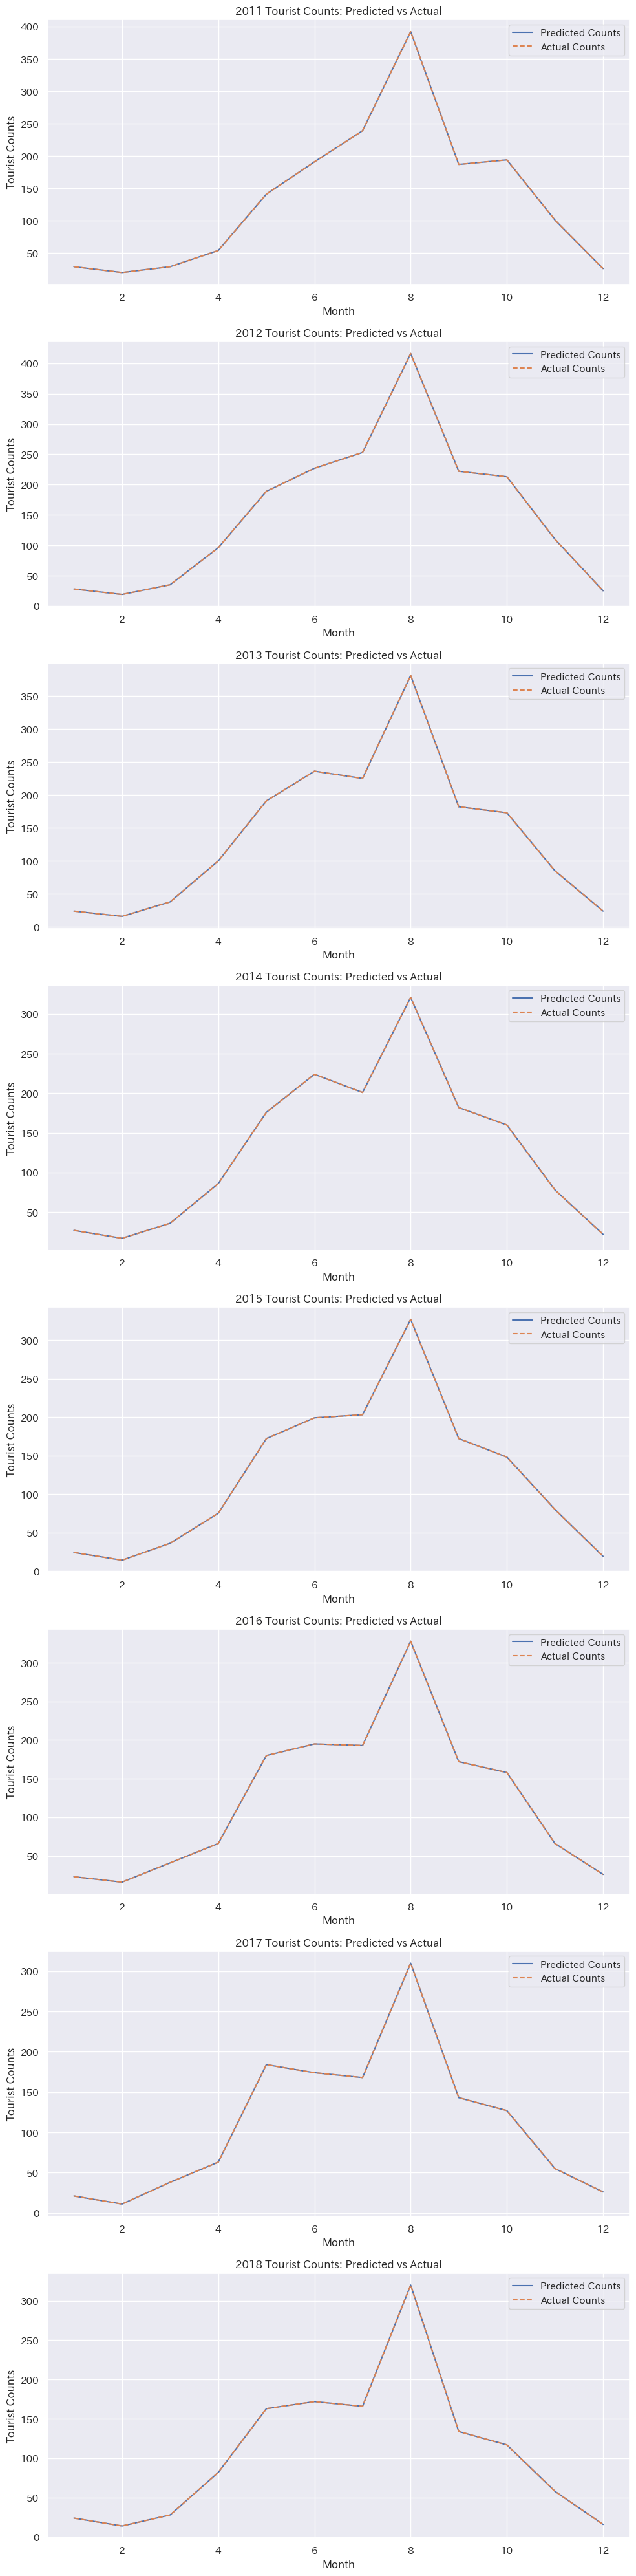

In [ ]:
# 年ごとに最適化された月別平均割合を計算する関数
def optimize_monthly_ratios_for_year(year):
    delta, lambda_ = calibrated_params[year]
    optimized_ratios = []

    for month in range(1, 13):
        def calculate_error(monthly_ratio):
            niigata_tourists = coefficients[month][0] * year + coefficients[month][1]
            sado_potential = niigata_tourists * (monthly_ratio + delta)
            review_adjustment = (annual_review_averages.get(year-1, 2.5) - 2.5) * lambda_
            predicted = sado_potential * (1 + review_adjustment)
            actual = actual_tourist_counts.get((year, month), 0)
            return abs(predicted - actual)

        result = minimize(calculate_error, 0.05)
        optimized_ratios.append(result.x[0])

    return optimized_ratios

# 各年の最適化された月別平均割合を計算し、グラフをプロット
fig, axs = plt.subplots(8, 1, figsize=(10, 40))

for i, year in enumerate(range(2011, 2019)):
    optimized_ratios = optimize_monthly_ratios_for_year(year)
    predicted_counts = []
    actual_counts = [actual_tourist_counts.get((year, m), 0) for m in range(1, 13)]

    for month, ratio in zip(range(1, 13), optimized_ratios):
        niigata_tourists = coefficients[month][0] * year + coefficients[month][1]
        sado_potential = niigata_tourists * (ratio + calibrated_params[year][0])
        review_adjustment = (annual_review_averages.get(year-1, 2.5) - 2.5) * calibrated_params[year][1]
        predicted = int(round(sado_potential * (1 + review_adjustment)))
        predicted_counts.append(predicted)

    axs[i].plot(range(1, 13), predicted_counts, label='Predicted Counts')
    axs[i].plot(range(1, 13), actual_counts, label='Actual Counts', linestyle='--')
    axs[i].set_title(f'{year} Tourist Counts: Predicted vs Actual')
    axs[i].set_xlabel('Month')
    axs[i].set_ylabel('Tourist Counts')
    axs[i].legend()

plt.tight_layout()
plt.show()


In [ ]:
# 各年の最適化された月別平均割合を計算し、データフレームに格納
data = []
for year in range(2011, 2019):
    optimized_ratios = optimize_monthly_ratios_for_year(year)
    for month, ratio in enumerate(optimized_ratios, start=1):
        data.append({
            'Year': year,
            'Month': month,
            'Optimized Ratio': ratio
        })

# データフレームの作成
optimized_ratios_df = pd.DataFrame(data)

# データフレームの表示
optimized_ratios_df


Year  Month  Optimized Ratio
0   2011      1        -0.019816
1   2011      2        -0.022071
2   2011      3        -0.018275
3   2011      4        -0.015848
4   2011      5        -0.003463
..   ...    ...              ...
91  2018      8         0.008207
92  2018      9         0.006613
93  2018     10         0.000225
94  2018     11        -0.005241
95  2018     12        -0.011616

[96 rows x 3 columns]

In [ ]:
# 各年の最適化された月別平均割合を計算
all_years_optimized_ratios = {}
for year in range(2011, 2019):
    all_years_optimized_ratios[year] = optimize_monthly_ratios_for_year(year)

# 各月の全年平均の月別平均割合を算出
monthly_average_ratios = []
for month in range(1, 13):
    monthly_total = 0
    for year in range(2011, 2019):
        monthly_total += all_years_optimized_ratios[year][month - 1]
    monthly_average = monthly_total / 8  # 8年間の平均
    monthly_average_ratios.append(monthly_average)

# 結果の表示
print("Monthly Average Ratios:", monthly_average_ratios)


Monthly Average Ratios: [-0.018600934431488653, -0.020400950472770286, -0.016323648235111166, -0.011260749892049329, 0.002058858373059372, 0.013267959256420304, 0.00543867242792035, 0.0032551617152760254, 0.006126235856362853, -0.0003756676326162969, -0.00857067024833134, -0.017240298021591844]


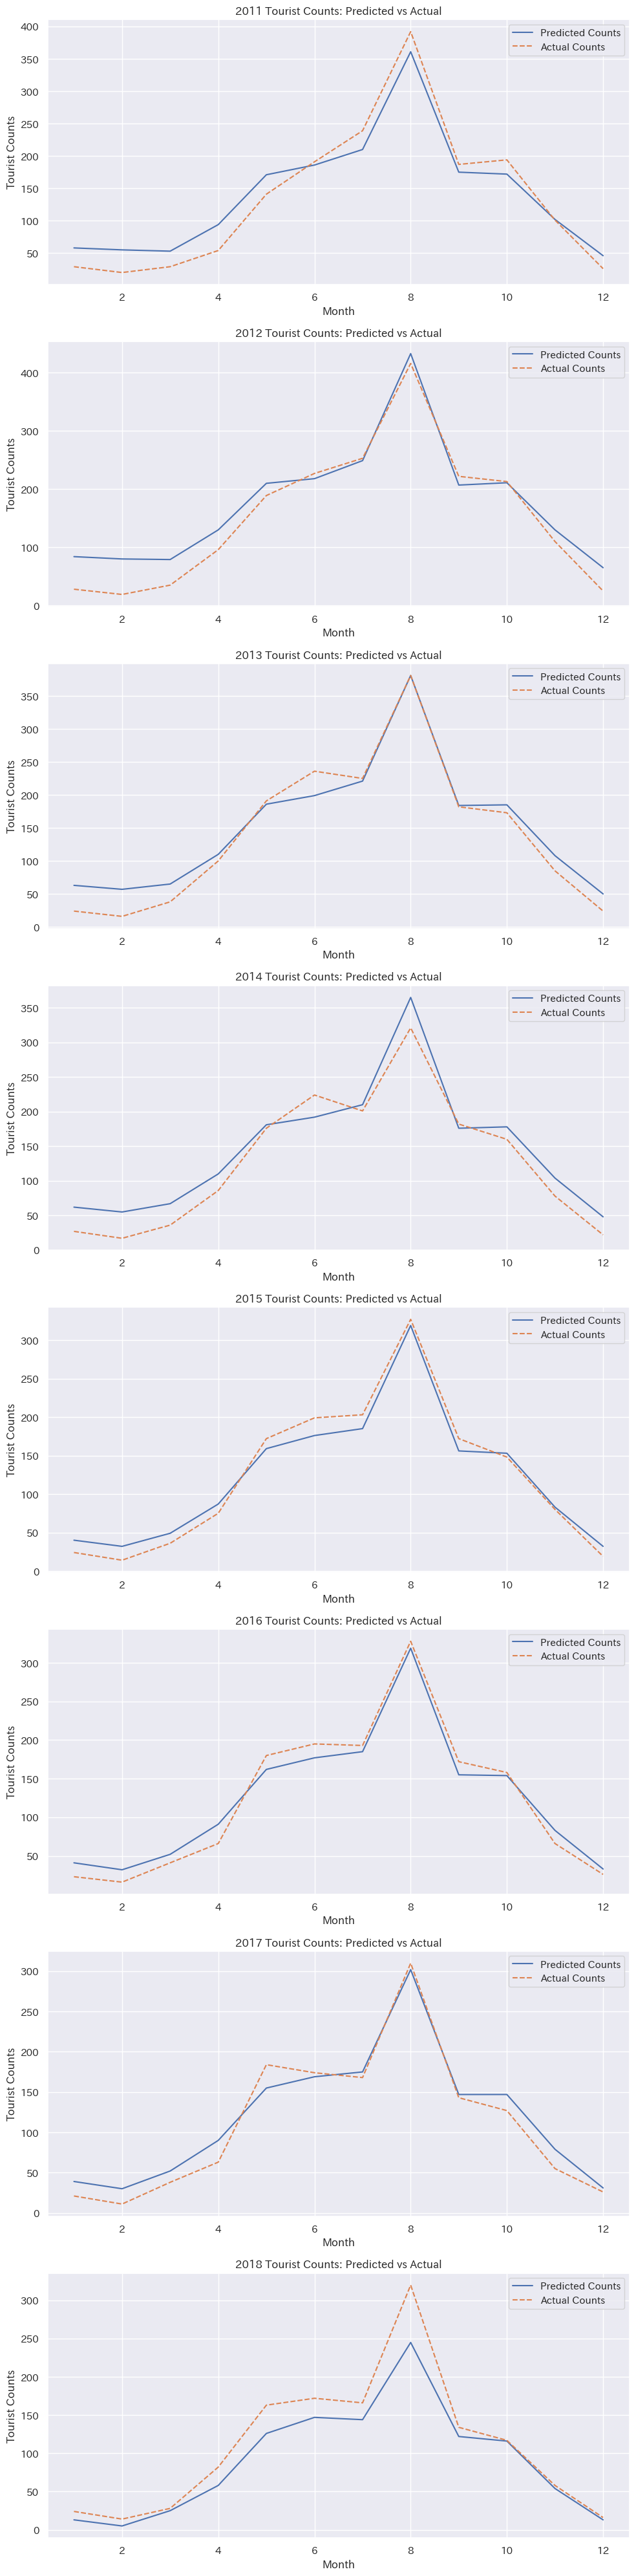

In [ ]:
# 月別平均割合
monthly_average_ratios = [-0.013378606954303655, -0.01468921242301886, -0.011726550812103453,
                          -0.008050605274971782, 0.001394634020823737, 0.009775035487700808,
                          0.00425331514222259, 0.0026015092432105356, 0.004595362944347498,
                          7.518520156755508e-05, -0.005902048809618914, -0.012402855629269537]

# 年別に予測値と実際の値をプロット
fig, axs = plt.subplots(8, 1, figsize=(10, 40))

for i, year in enumerate(range(2011, 2019)):
    delta, lambda_ = calibrated_params[year]
    predicted_counts = []
    actual_counts = [actual_tourist_counts.get((year, m), 0) for m in range(1, 13)]

    for month in range(1, 13):
        niigata_tourists = coefficients[month][0] * year + coefficients[month][1]
        sado_potential = niigata_tourists * (monthly_average_ratios[month - 1] + delta)
        review_adjustment = (annual_review_averages.get(year - 1, 2.5) - 2.5) * lambda_
        predicted = int(round(sado_potential * (1 + review_adjustment)))
        predicted_counts.append(predicted)

    axs[i].plot(range(1, 13), predicted_counts, label='Predicted Counts')
    axs[i].plot(range(1, 13), actual_counts, label='Actual Counts', linestyle='--')
    axs[i].set_title(f'{year} Tourist Counts: Predicted vs Actual')
    axs[i].set_xlabel('Month')
    axs[i].set_ylabel('Tourist Counts')
    axs[i].legend()

plt.tight_layout()
plt.show()


##平均λ、Δバージョン


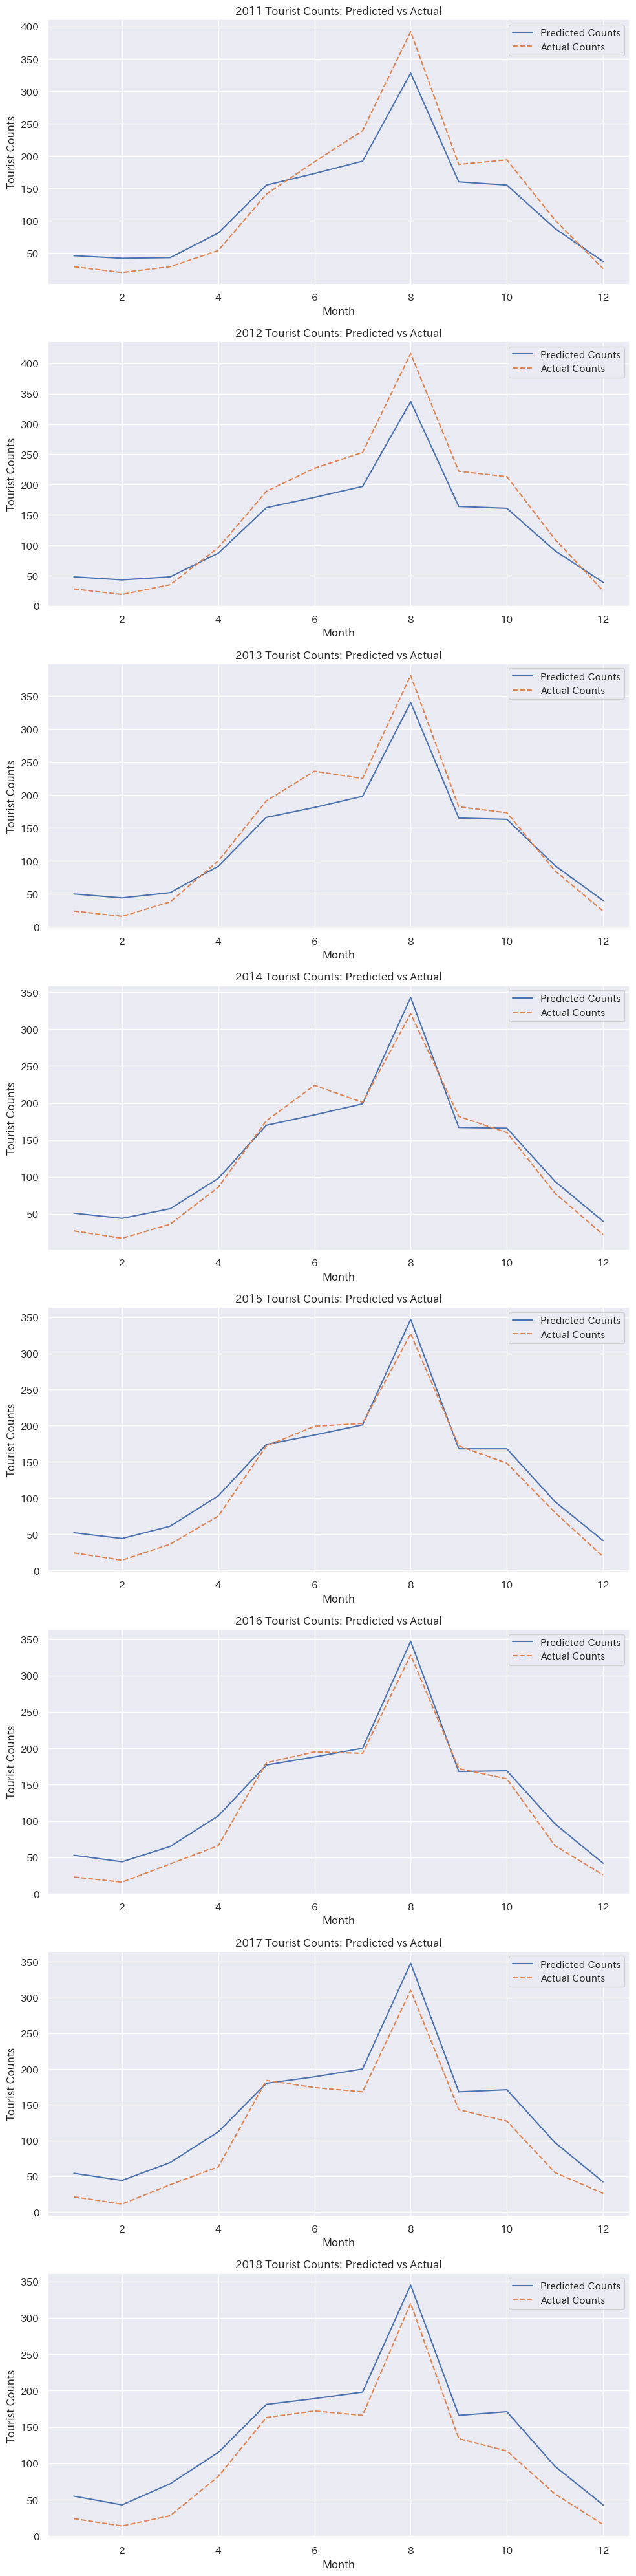

In [ ]:
# 平均Δと平均λを使用して年ごとの予測値をプロットする関数
def plot_predicted_vs_actual_with_averages():
    fig, axs = plt.subplots(8, 1, figsize=(10, 40))

    for i, year in enumerate(range(2011, 2019)):
        predicted_counts = []
        actual_counts = [actual_tourist_counts.get((year, m), 0) for m in range(1, 13)]

        for month in range(1, 13):
            niigata_tourists = coefficients[month][0] * year + coefficients[month][1]
            sado_potential = niigata_tourists * (monthly_average_ratios[month - 1] + average_delta)
            review_adjustment = (annual_review_averages.get(year - 1, 2.5) - 2.5) * average_lambda
            predicted = int(round(sado_potential * (1 + review_adjustment)))
            predicted_counts.append(predicted)

        axs[i].plot(range(1, 13), predicted_counts, label='Predicted Counts')
        axs[i].plot(range(1, 13), actual_counts, label='Actual Counts', linestyle='--')
        axs[i].set_title(f'{year} Tourist Counts: Predicted vs Actual')
        axs[i].set_xlabel('Month')
        axs[i].set_ylabel('Tourist Counts')
        axs[i].legend()

    plt.tight_layout()
    plt.show()

# 月別平均割合
monthly_average_ratios = [-0.013378606954303655, -0.01468921242301886, -0.011726550812103453,
                          -0.008050605274971782, 0.001394634020823737, 0.009775035487700808,
                          0.00425331514222259, 0.0026015092432105356, 0.004595362944347498,
                          7.518520156755508e-05, -0.005902048809618914, -0.012402855629269537]

# 平均Δと平均λの計算
total_delta = sum(params[0] for params in calibrated_params.values())
total_lambda = sum(params[1] for params in calibrated_params.values())
average_delta = total_delta / len(calibrated_params)
average_lambda = total_lambda / len(calibrated_params)

# 予測と実際のデータをプロットする関数を修正して再実行
plot_predicted_vs_actual_with_averages()



In [ ]:
average_delta

0.02368421052631579

In [ ]:
average_delta

0.02368421052631579

##観光客生成

In [ ]:
review_averages = {
    2011: 2.9258606425670117,
    2012: 3.0164292657943963,
    2013: 3.110876348585283,
    2014: 3.2203552079844324,
    2015: 3.1497245451183953,
    2016: 3.1512590863985337,
    2017: 2.932871734209716,
    2018: 2.966819683388602
}

calibrated_params = {
    2011: (0.021052631578947368, 0.9473684210526315),
    2012: (0.021052631578947368, 1.263157894736842),
    2013: (0.02631578947368421, 0.21052631578947367),
    2014: (0.015789473684210527, 0.9473684210526315),
    2015: (0.015789473684210527, 0.8421052631578947),
    2016: (0.015789473684210527, 0.9473684210526315),
    2017: (0.010526315789473684, 1.263157894736842),
    2018: (0.010526315789473684, 1.3684210526315788)
}

# 月別平均比率
monthly_average_ratios = [-0.013378606954303655, -0.01468921242301886, -0.011726550812103453,
                          -0.008050605274971782, 0.001394634020823737, 0.009775035487700808,
                          0.00425331514222259, 0.0026015092432105356, 0.004595362944347498,
                          7.518520156755508e-05, -0.005902048809618914, -0.012402855629269537]


In [ ]:
# 平均Δと平均λの計算
total_delta = sum(params[0] for params in calibrated_params.values())
total_lambda = sum(params[1] for params in calibrated_params.values())
average_delta = total_delta / len(calibrated_params)
average_lambda = total_lambda / len(calibrated_params)

In [ ]:
# 佐渡島への実際の観光客数を計算する関数
def calculate_sado_tourists(year, month, delta, lambda_, review_averages):
    niigata_tourists = coefficients[month][0] * year + coefficients[month][1]
    sado_potential = niigata_tourists * (monthly_average_ratios[month - 1] + delta)
    review_adjustment = (review_averages.get(year - 1, 2.5) - 2.5) * lambda_
    sado_tourists = int(round(sado_potential * (1 + review_adjustment)))
    return sado_tourists

def create_yearly_predicted_counts(years, average_ratios, coefficients, review_averages, calibrated_params, average_delta, average_lambda):
    yearly_predicted_counts = {}
    for year in years:
        predicted_counts = []
        for month in range(1, 13):
            if year <= 2018:
                delta, lambda_value = calibrated_params[year]
            else:
                delta, lambda_value = average_delta, average_lambda

            predicted = calculate_sado_tourists(year, month, delta, lambda_value, review_averages)
            predicted_counts.append([month, predicted])

        df = pd.DataFrame(predicted_counts, columns=['Month', 'Predicted_Tourists'])
        df.set_index('Month', inplace=True)
        yearly_predicted_counts[year] = df

    return yearly_predicted_counts


##データベース生成関数

In [ ]:
def generate_tourists(num_tourists, preference_std_dev, year, month):
    tourists = []
    start_date = pd.Timestamp(f'{year}-{month:02d}-01')
    end_date = pd.Timestamp(f'{year}-{month:02d}-{pd.Timestamp(start_date).days_in_month}')

    for i in range(num_tourists):
        budget = random.choices([1, 2, 3, 4], weights=[0.06, 0.36, 0.37, 0.21])[0]
        pref1 = max(1, min(5, random.gauss(3, 0.5)))
        pref2 = max(1, min(5, random.gauss(4, 0.5)))
        pref3 = max(1, min(5, random.gauss(1, 0.5)))
        preference = [pref1, pref2, pref3, 5]
        schedule_pref = random.choices([0, 1], weights=[0.6, 0.4])[0]
        stay_duration = random.choices([0, 1, 2, 3, 4], weights=[0.3, 0.3, 0.2, 0.1, 0.1])[0]

        # 時間情報を含まない日付をランダムに選択
        random_days = random.randint(0, (end_date - start_date).days)
        initial_day = start_date + timedelta(days=random_days)

        tourists.append([
            i + 1, budget, *preference, schedule_pref, stay_duration,
            0, 0, 0, 0, initial_day, 0
        ])

    columns = [
        "ID", "Budget", "Pref1", "Pref2", "Pref3", "Pref4", "Schedule_pref",
        "Stay_duration", "Expectation", "Experience",
        "Satisfaction", "Review", "Initial_day", "select_plan"
    ]
    tourists = pd.DataFrame(tourists, columns=columns)

    return tourists


def generate_facilities():
    facilities = [
        ["大佐渡スカイライン", 0.3, 5, 2, 1, 2],
        ["白雲台", 0.7, 5, 1, 1, 3],
        ["大野亀", 0.7, 5, 1, 1, 4],
        ["二ツ亀", 0.5, 5, 1, 3, 1],
        ["平根崎", 0.8, 5, 5, 4, 3],
        ["尖閣湾揚島遊園", 0.4, 5, 1, 2, 3],
        ["玉堂窯", 0.4, 1, 1, 1, 4],
        ["佐渡金山", 0.7, 5, 1, 2, 5],
        ["北沢浮遊選鉱場", 0.5, 2, 1, 1, 4],
        ["きらりうむ佐渡", 0.7, 2, 1, 1, 5],
        ["めおと岩観光", 0.8, 5, 1, 1, 3],
        ["妙宣寺", 0.5, 3, 1, 1, 4],
        ["根本寺", 0.4, 3, 1, 1, 3],
        ["トキの森公園", 0.4, 4, 1, 2, 2],
        ["佐渡博物館", 0.7, 3, 1, 1, 5],
        ["両津郷土博物館", 0.6, 3, 1, 1, 5],
        ["真野御陵", 0.6, 4, 1, 1, 5],
        ["長浜荘", 0.3, 3, 1, 1, 2],
        ["佐渡歴史伝説館", 0.7, 2, 1, 1, 4],
        ["佐渡西三川ゴールドパーク", 0.8, 3, 1, 2, 3],
        ["尾畑酒造", 0.5, 1, 1, 1, 4],
        ["蓮華峰寺", 0.6, 4, 1, 1, 4],
        ["矢島・経島", 0.2, 4, 2, 4, 2],
        ["力屋観光汽船", 0.2, 4, 2, 5, 2],
        ["宿根木集落", 0.5, 3, 1, 1, 3],
        ["小木民俗博物館", 0.6, 1, 1, 3, 3],
        ["小木家（小木港）", 0.8, 2, 1, 1, 2],
        ["北雪酒造", 0.2, 1, 1, 1, 4]
    ]

    columns = ["Facility_name", "congestion", "Attr1", "Attr2", "Attr3", "Attr4"]
    facilities_df = pd.DataFrame(facilities, columns=columns)
    return facilities_df

def create_plan(plan_id, facilities, plan_name, is_specific_facility_plan=False):
    # Attr1, Attr2, Attr3, および Attr4 の値を取得
    attributes = facilities[['Attr1', 'Attr2', 'Attr3', 'Attr4']].values
    congestions = facilities['congestion'].values
    sights = facilities['Facility_name'].values.tolist()

    # 平均値を計算（Attr4を含む）
    attributes_avg = np.mean(attributes, axis=0)
    congestions_avg = np.mean(congestions)

    price = random.choices([1, 2, 3, 4], [0.1, 0.3, 0.4, 0.2])[0]
    selected_count = 0
    initial_rating = 3
    days = random.choice([0, 1, 2, 3, 4])
    deterioration = random.uniform(3, 5)

    # 佐渡金山を含むプランの広告力を0.5に設定、それ以外は0から0.2の間でランダム
    ad_power = 0.5 if is_specific_facility_plan else random.uniform(0, 0.2)

    return {
        "ID": plan_id,
        "Plan_name": plan_name,
        "Attr1": attributes_avg[0],
        "Attr2": attributes_avg[1],
        "Attr3": attributes_avg[2],
        "Attr4": attributes_avg[3],  # Attr4の平均値を追加
        "Price": price,
        "Initial_rating": initial_rating,
        "Ad_power": ad_power,
        "Selected_count": selected_count,
        "Congestion": congestions_avg,
        "Days": days,
        "Sights": ', '.join(sights),
        "Deterioration": deterioration
    }


def generate_plans(num_single, num_double, num_triple, facilities, specific_facility_name):
    plans = []
    plan_id = 1

    # 特定の施設（例えば「佐渡金山」）を含むプランを生成
    specific_facility = facilities[facilities['Facility_name'] == specific_facility_name].iloc[0]
    plans.append(create_plan(plan_id, pd.DataFrame([specific_facility]), f"Plan_{plan_id}", True))
    plan_id += 1

    # 佐渡金山と他の施設を含む2つのプランを生成
    for _ in range(2):
        other_facility = facilities[facilities['Facility_name'] != specific_facility_name].sample()
        combined_facilities = pd.concat([pd.DataFrame([specific_facility]), other_facility])
        plans.append(create_plan(plan_id, combined_facilities, f"Plan_{plan_id}", True))
        plan_id += 1

    # 残りのプランを生成
    remaining_single = num_single - 1
    remaining_double = num_double - 1
    remaining_triple = num_triple - 1

    # 各施設を単体で含むプランを生成
    for _, fac in facilities.iterrows():
        if remaining_single > 0:
            plan = create_plan(plan_id, pd.DataFrame([fac]), f"Plan_{plan_id}")
            plans.append(plan)
            plan_id += 1
            remaining_single -= 1

    # ランダムに2施設を含むプランを生成
    for _ in range(remaining_double):
        selected_facilities = facilities.sample(2)
        plan = create_plan(plan_id, selected_facilities, f"Plan_{plan_id}")
        plans.append(plan)
        plan_id += 1

    # ランダムに3施設を含むプランを生成
    for _ in range(remaining_triple):
        selected_facilities = facilities.sample(3)
        plan = create_plan(plan_id, selected_facilities, f"Plan_{plan_id}")
        plans.append(plan)
        plan_id += 1

    return pd.DataFrame(plans)

def generate_crowd(year, num_days):
    # 平日と土日の混雑度を定義する
    weekday_congestion = np.random.uniform(low=0.3, high=0.7, size=(num_days,))
    weekend_congestion = weekday_congestion * 1.5  # 土日は混雑度を1.5倍にする

    # 繁忙期の混雑度を定義する
    busy_months = [1, 3, 7, 8, 12]
    month_congestion = np.ones((num_days,))

    for i in busy_months:
        days_in_month = cal.monthrange(year, i)[1]
        start_day = sum(cal.monthrange(year, m)[1] for m in range(1, i))
        end_day = min(start_day + days_in_month, num_days)  # 配列のサイズを超えないように調整
        month_congestion[start_day:end_day] *= 1.4

    # 混雑度を計算
    congestion = []
    dates = []

    for month in range(1, 13):
        for day in range(1, cal.monthrange(year, month)[1] + 1):
            date = f"{year}-{month:02d}-{day:02d}"
            dates.append(date)
            day_of_week = cal.weekday(year, month, day)
            if day_of_week in [5, 6]:  # 土日
                congestion_value = weekend_congestion[len(congestion) % num_days] * (1.4 if month in busy_months else 1)
            else:  # 平日
                congestion_value = weekday_congestion[len(congestion) % num_days] * (1.4 if month in busy_months else 1)
            congestion.append(min(congestion_value, 1.0))  # 混雑度の最大値を1に制限

    crowd_df = pd.DataFrame({"Date": dates, "Congestion": congestion})
    return crowd_df.sample(frac=1).reset_index(drop=True)  # ランダムにシャッフルしてから返す

def is_leap_year(year):
    return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)

def adjust_ad_power(plans, ad_power_change):
    adjusted_plans = plans.copy()
    adjusted_plans['Ad_power'] = adjusted_plans['Ad_power'] + ad_power_change
    return adjusted_plans



##シミュレーション関数

In [ ]:
def select_plans(selected_tourists, plans):
   for index, tourist in selected_tourists.iterrows():
       # 観光客の選好ベクトルを作成（Pref4を追加）
       pref_vec = np.array([tourist['Pref1'], tourist['Pref2'], tourist['Pref3'], tourist['Pref4']])

       # plansのAttrベクトルを作成し、観光客の選好ベクトルとのコサイン類似度を計算（Attr4を含める）
       plans_vec = plans[['Attr1', 'Attr2', 'Attr3', 'Attr4']].values
       similarity = cosine_similarity(pref_vec.reshape(1, -1), plans_vec)

       # コサイン類似度が大きい順にplansを並べ替え
       plans['similarity'] = similarity.reshape(-1)
       sorted_plans = plans.sort_values(['similarity'], ascending=False)

       # 観光客のStay_durationとplansのDaysが一致するもののみを選択
       sorted_plans = sorted_plans[sorted_plans['Days'] == tourist['Stay_duration']]

       # 予算に近い順に並び替えのためのコピーを作成
       sorted_plans_copy = sorted_plans.copy()
       sorted_plans_copy.loc[:, 'budget_diff'] = abs(sorted_plans_copy['Price'] - tourist['Budget'])
       sorted_plans_copy = sorted_plans_copy.sort_values(['budget_diff'])

       # Initial_ratingが大きい順に並び替え
       sorted_plans_copy = sorted_plans_copy.sort_values(['Initial_rating'], ascending=False)

       # 0.05の確率でランダムに並び替え
       if np.random.random() < 0.2:
           sorted_plans_copy = sorted_plans_copy.sample(frac=1).reset_index(drop=True)

       # 最も上にあるプランを実行プランとして選択
       selected_plan = sorted_plans_copy.iloc[0]

       # plansのSelected_countに1を足す
       plans.loc[plans['ID'] == selected_plan['ID'], 'Selected_count'] += 1

       # selected_touristsのselect_planに選択されたプランのIDを入力
       selected_tourists.at[index, 'select_plan'] = selected_plan['ID']

   return selected_tourists


# 観光客に期待値が初期値として10点与えられる
INITIAL_EXPECTATION = 10

def calculate_expectation(selected_tourists, plans):
    for i, row in selected_tourists.iterrows():
        plan_id = row['select_plan']
        selected_plan = plans.loc[plans['ID'] == plan_id].iloc[0]

        # ゼロ除算や異常な値がないかチェック
        if selected_plan['Selected_count'] == 0 or np.isinf(selected_plan['Initial_rating']):
            print(f"Warning: Plan ID {plan_id} has an initial rating of {selected_plan['Initial_rating']} with {selected_plan['Selected_count']} selections.")
            continue

        # selected_planに書かれているIDのプランを取り出す
        selected_plan = plans[plans['ID'] == row['select_plan']].iloc[0]

        # 観光客の選好ベクトルを作成（Attr4とPref4を含む）
        pref_vector = np.array([row['Pref1'], row['Pref2'], row['Pref3'], row['Pref4']])

        # プランのAttrベクトルを作成（Attr4を含む）し、観光客の選好ベクトルとのコサイン類似度を計算
        attr_vector = selected_plan[['Attr1', 'Attr2', 'Attr3', 'Attr4']].to_numpy()
        similarity = cosine_similarity([pref_vector], [attr_vector])

        # 嗜好を計算し、データフレームに記入
        element1 = similarity[0][0] * 0.15
        selected_tourists.at[i, 'element1'] = element1

        # 金額を基にした要素の計算（0.6点満点）
        element2 = (selected_plan['Price'] / 4) * 0.6
        selected_tourists.at[i, 'element2'] = element2

        # 評価点数を基にした要素の計算（0.6点満点）
        element3 = (selected_plan['Initial_rating'] / 5) * 0.6
        selected_tourists.at[i, 'element3'] = element3

        # Ad_powerをデータフレームに記入
        ad_power = selected_plan['Ad_power']
        selected_tourists.at[i, 'Ad_power'] = ad_power

        # 期待値を計算
        expectation = (element1 + element2 + element3 + ad_power) * INITIAL_EXPECTATION
        selected_tourists.at[i, 'Expectation'] = expectation

    return selected_tourists


def calculate_experience(selected_plans, plans, Ship_congestion_df):
    for i, tourist in selected_plans.iterrows():
        # 選択されたプランの詳細を取得
        selected_plan = plans.loc[plans["ID"] == tourist["select_plan"]].iloc[0]

        # 'deterioration' 値をプランデータから取得
        deterioration = selected_plan["Deterioration"]

        # 'congestion' 値を計算
        congestion = selected_plan["Congestion"]
        if congestion <= 0.5:
            congestion_value = 5
        elif 0.5 < congestion < 0.8:
            congestion_value = 4
        elif 0.8 <= congestion <= 1.0:
            congestion_value = 3
        elif 1.0 < congestion < 1.2:
            congestion_value = 2
        elif 1.2 <= congestion < 1.4:
            congestion_value = 1
        else:
            congestion_value = 0

        # 観光客の 'Initial_day' と 'Ship_congestion_df' の 'Date' が一致するか確認し、'traffic' 値を計算
        ship_congestion_row = Ship_congestion_df[Ship_congestion_df["Date"] == tourist["Initial_day"].strftime("%Y-%m-%d")]
        if not ship_congestion_row.empty:
            ship_congestion = ship_congestion_row["Congestion"].iloc[0]
            if 0.4 <= ship_congestion < 0.7:
                ship_value = 5
            elif 0.7 <= ship_congestion < 0.9:
                ship_value = 3
            elif 0.9 <= ship_congestion < 1:
                ship_value = 1
            else:
                ship_value = 0
        else:
            ship_value = 0  # または適切なデフォルト値を設定

        # 'Overall satisfaction' をランダム値で計算
        overall_satisfaction = np.random.uniform(2, 5)
        if np.random.random() < 0.01:
            overall_satisfaction = 1

        # 'Experience' を計算し、データフレームに割り当て
        experience = congestion_value + deterioration + ship_value + overall_satisfaction
        selected_plans.at[i, 'congestion'] = congestion_value
        selected_plans.at[i, 'deterioration'] = deterioration
        selected_plans.at[i, 'traffic'] = ship_value
        selected_plans.at[i, 'Other'] = overall_satisfaction
        selected_plans.at[i, 'Experience'] = experience

    return selected_plans

def calculate_satisfaction(row, plans):
    experience = row['Experience']
    expectation = row['Expectation']
    select_plan = row['select_plan']

    # 選択したプランの選択回数を取得
    selected_count = plans.loc[plans['ID'] == select_plan, 'Selected_count'].iloc[0]

    # 選択回数に基づいた調整係数を適用
    adjustment = np.log(selected_count + 1)

    # 満足度の計算
    satisfaction = (experience - expectation) * adjustment
    return satisfaction

# 満足度をレビューに変換
def scale_to_review(satisfaction, min_satisfaction, max_satisfaction):
    if max_satisfaction == min_satisfaction:  # 分母が0になるのを防ぐ
        return 1 if satisfaction >= 0 else 5  # 体験が期待を上回れば最高点、下回れば最低点
    scaled_satisfaction = 1 + (satisfaction - min_satisfaction) / (max_satisfaction - min_satisfaction) * 4
    review = round(scaled_satisfaction, 1)  # 小数点第一位で四捨五入
    return review

def update_plan_ratings(selected_plans, plans):
    for index, row in selected_plans.iterrows():
        plan_id = row['select_plan']
        review = row['Review']

        current_rating = plans.loc[plans['ID'] == plan_id, 'Initial_rating'].iloc[0]
        selected_count = plans.loc[plans['ID'] == plan_id, 'Selected_count'].iloc[0]

        # 選択回数が少ない場合の調整
        if selected_count < 5:  # 例として5回を閾値とする
            weight = 0.5  # 重み付けを半分にする
        else:
            weight = 1  # 通常の重み付け

        new_total_rating = (current_rating * selected_count * weight) + review
        new_rating = new_total_rating / ((selected_count + 1) * weight)

        plans.loc[plans['ID'] == plan_id, 'Initial_rating'] = new_rating
        plans.loc[plans['ID'] == plan_id, 'Selected_count'] = selected_count + 1

    return plans



In [ ]:
def run_simulation(yearly_counts_dict, facilities, plans, specified_year):
    simulation_results = {}

    predicted_counts_df = yearly_counts_dict[specified_year]
    crowd_df = generate_crowd(specified_year, 365)

    for month, row in predicted_counts_df.iterrows():
        num_tourists = row['Predicted_Tourists']
        tourists = generate_tourists(num_tourists, 1, specified_year, month)

        selected_tourists = select_plans(tourists, plans)
        selected_tourists = calculate_expectation(selected_tourists, plans)

        # 混雑度を更新
        for plan_id in plans['ID']:
            selected_count = selected_tourists[selected_tourists['select_plan'] == plan_id].shape[0]
            congestion_value = min(selected_count / 10, 1)
            plans.loc[plans['ID'] == plan_id, 'Congestion'] = congestion_value

        selected_tourists = calculate_experience(selected_tourists, plans, crowd_df)

        # Satisfaction列の計算と追加
        for index, row in selected_tourists.iterrows():
            satisfaction = calculate_satisfaction(row, plans)
            selected_tourists.at[index, 'Satisfaction'] = satisfaction

        max_satisfaction = selected_tourists['Satisfaction'].max()
        min_satisfaction = selected_tourists['Satisfaction'].min()
        selected_tourists['Review'] = selected_tourists['Satisfaction'].apply(lambda s: scale_to_review(s, min_satisfaction, max_satisfaction))

        # プランのレビューと選択回数を更新
        plans = update_plan_ratings(selected_tourists, plans)

        simulation_results[(specified_year, month)] = selected_tourists

    return simulation_results, plans


##シミュレーション実行

In [ ]:
# 平均Δと平均λの計算
total_delta = sum(params[0] for params in calibrated_params.values())
total_lambda = sum(params[1] for params in calibrated_params.values())
average_delta = total_delta / len(calibrated_params)
average_lambda = total_lambda / len(calibrated_params)

# 2012年から2019年までの予測された観光客数を計算
predicted_counts_2012_2019 = create_yearly_predicted_counts(range(2012, 2020), average_ratios, coefficients, review_averages, calibrated_params, average_delta, average_lambda)

# 施設データベースの生成
facilities = generate_facilities()

# プランの生成
# 各施設を単体で含むプランを28個、ランダムに2施設を含むプランを41個、ランダムに3施設を含むプランを41個生成
plans = generate_plans(28, 41, 41, facilities, "佐渡金山")


In [ ]:
# Generate yearly predicted counts for 2023 to 2027
years = range(2023, 2027)
yearly_predicted_counts = create_yearly_predicted_counts(years, average_ratios, coefficients, review_averages, calibrated_params, average_delta, average_lambda)

# Run the simulation for each year and store the results
all_simulation_results = {}
for year in years:
    simulation_results, updated_plans = run_simulation(yearly_predicted_counts, facilities, plans, year)
    all_simulation_results[year] = simulation_results


In [ ]:
yearly_predicted_counts

{2023:        Predicted_Tourists
 Month                    
 1                      21
 2                      11
 3                      40
 4                      78
 5                     141
 6                     154
 7                     148
 8                     256
 9                     126
 10                    126
 11                     61
 12                     19,
 2024:        Predicted_Tourists
 Month                    
 1                      22
 2                      11
 3                      42
 4                      81
 5                     144
 6                     156
 7                     148
 8                     257
 9                     126
 10                    127
 11                     62
 12                     19,
 2025:        Predicted_Tourists
 Month                    
 1                      22
 2                      11
 3                      44
 4                      83
 5                     146
 6                     157
 7      

##データフレーム結合

In [ ]:
# 2024年から2026年までの結果を分析用にまとめる
analysis_results = {}
for year in range(2024, 2027):
    analysis_results[year] = all_simulation_results[year]

In [ ]:
analysis_results

{2024: {(2024,
   1):     ID  Budget     Pref1     Pref2     Pref3  Pref4  Schedule_pref  \
  0    1       3  2.292226  3.677244  1.000000      5              0   
  1    2       2  2.616251  4.110101  1.273821      5              0   
  2    3       2  3.178776  3.452265  1.000000      5              0   
  3    4       3  3.088231  4.369239  1.395134      5              1   
  4    5       2  3.759789  3.199907  1.203751      5              0   
  5    6       4  3.381622  3.994217  1.000000      5              0   
  6    7       3  3.789399  4.396033  1.706347      5              1   
  7    8       1  2.534248  2.815183  1.000000      5              1   
  8    9       3  3.923731  3.745401  1.768332      5              0   
  9   10       3  3.362972  4.177388  2.093008      5              1   
  10  11       1  2.780882  4.700692  1.000000      5              0   
  11  12       3  3.749843  4.042793  1.000000      5              0   
  12  13       4  3.163074  3.994443  1.0000

##分析

In [ ]:
plans

ID Plan_name     Attr1     Attr2     Attr3     Attr4  Price  \
0      1    Plan_1  5.000000  1.000000  2.000000  5.000000      2   
1      2    Plan_2  3.000000  1.000000  1.500000  4.500000      2   
2      3    Plan_3  4.000000  1.000000  1.500000  4.500000      2   
3      4    Plan_4  5.000000  2.000000  1.000000  2.000000      3   
4      5    Plan_5  5.000000  1.000000  1.000000  3.000000      4   
..   ...       ...       ...       ...       ...       ...    ...   
105  106  Plan_106  2.666667  1.000000  1.333333  3.333333      1   
106  107  Plan_107  3.666667  1.000000  1.333333  4.000000      4   
107  108  Plan_108  2.666667  1.000000  1.000000  4.333333      1   
108  109  Plan_109  4.333333  2.333333  2.333333  3.000000      2   
109  110  Plan_110  2.666667  1.000000  1.000000  4.000000      2   

     Initial_rating  Ad_power  Selected_count  Congestion  Days  \
0          2.116441  0.500000              18         0.0     0   
1          2.816483  0.500000              30         0.0     4   
2          2.238357  0.500000              22         0.0     1   
3          2.380996  0.156240              18         0.0     0   
4          2.662213  0.110335              34         0.0     0   
..              ...       ...             ...         ...   ...   
105        3.220624  0.170558              96         0.0     4   
106        2.703323  0.090758              18         0.0     4   
107        3.094738  0.004271              26         0.0     1   
108        2.942147  0.108004              24         0.0     2   
109        3.387467  0.104703              78         0.0     1   

                        Sights  Deterioration  similarity  
0                         佐渡金山       4.939878    0.907330  
1                   佐渡金山, 尾畑酒造       3.797881    0.926014  
2                    佐渡金山, 妙宣寺       3.586361    0.923615  
3                    大佐渡スカイライン       3.038538    0.877938  
4                          白雲台       4.137827    0.878042  
..                         ...            ...         ...  
105          トキの森公園, 妙宣寺, 北雪酒造       3.501138    0.939887  
106        真野御陵, 佐渡博物館, トキの森公園       4.809507    0.929360  
107      北沢浮遊選鉱場, 両津郷土博物館, 妙宣寺       3.809638    0.932929  
108  佐渡西三川ゴールドパーク, めおと岩観光, 平根崎       3.198820    0.929741  
109          宿根木集落, 真野御陵, 尾畑酒造       4.850573    0.939010  

[110 rows x 15 columns]

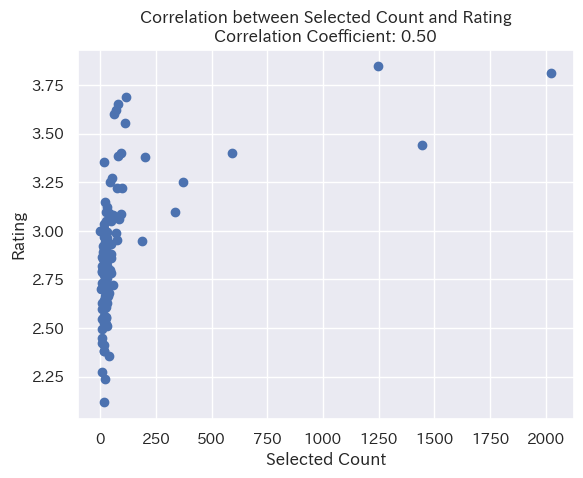

In [ ]:
# plans データフレームから選択回数と評価のデータを取得
selected_counts = plans['Selected_count']
ratings = plans['Initial_rating']

# 相関係数を計算
correlation_coefficient = np.corrcoef(selected_counts, ratings)[0, 1]

# 散布図を作成
plt.scatter(selected_counts, ratings)
plt.xlabel('Selected Count')
plt.ylabel('Rating')
plt.title(f'Correlation between Selected Count and Rating\nCorrelation Coefficient: {correlation_coefficient:.2f}')
plt.show()


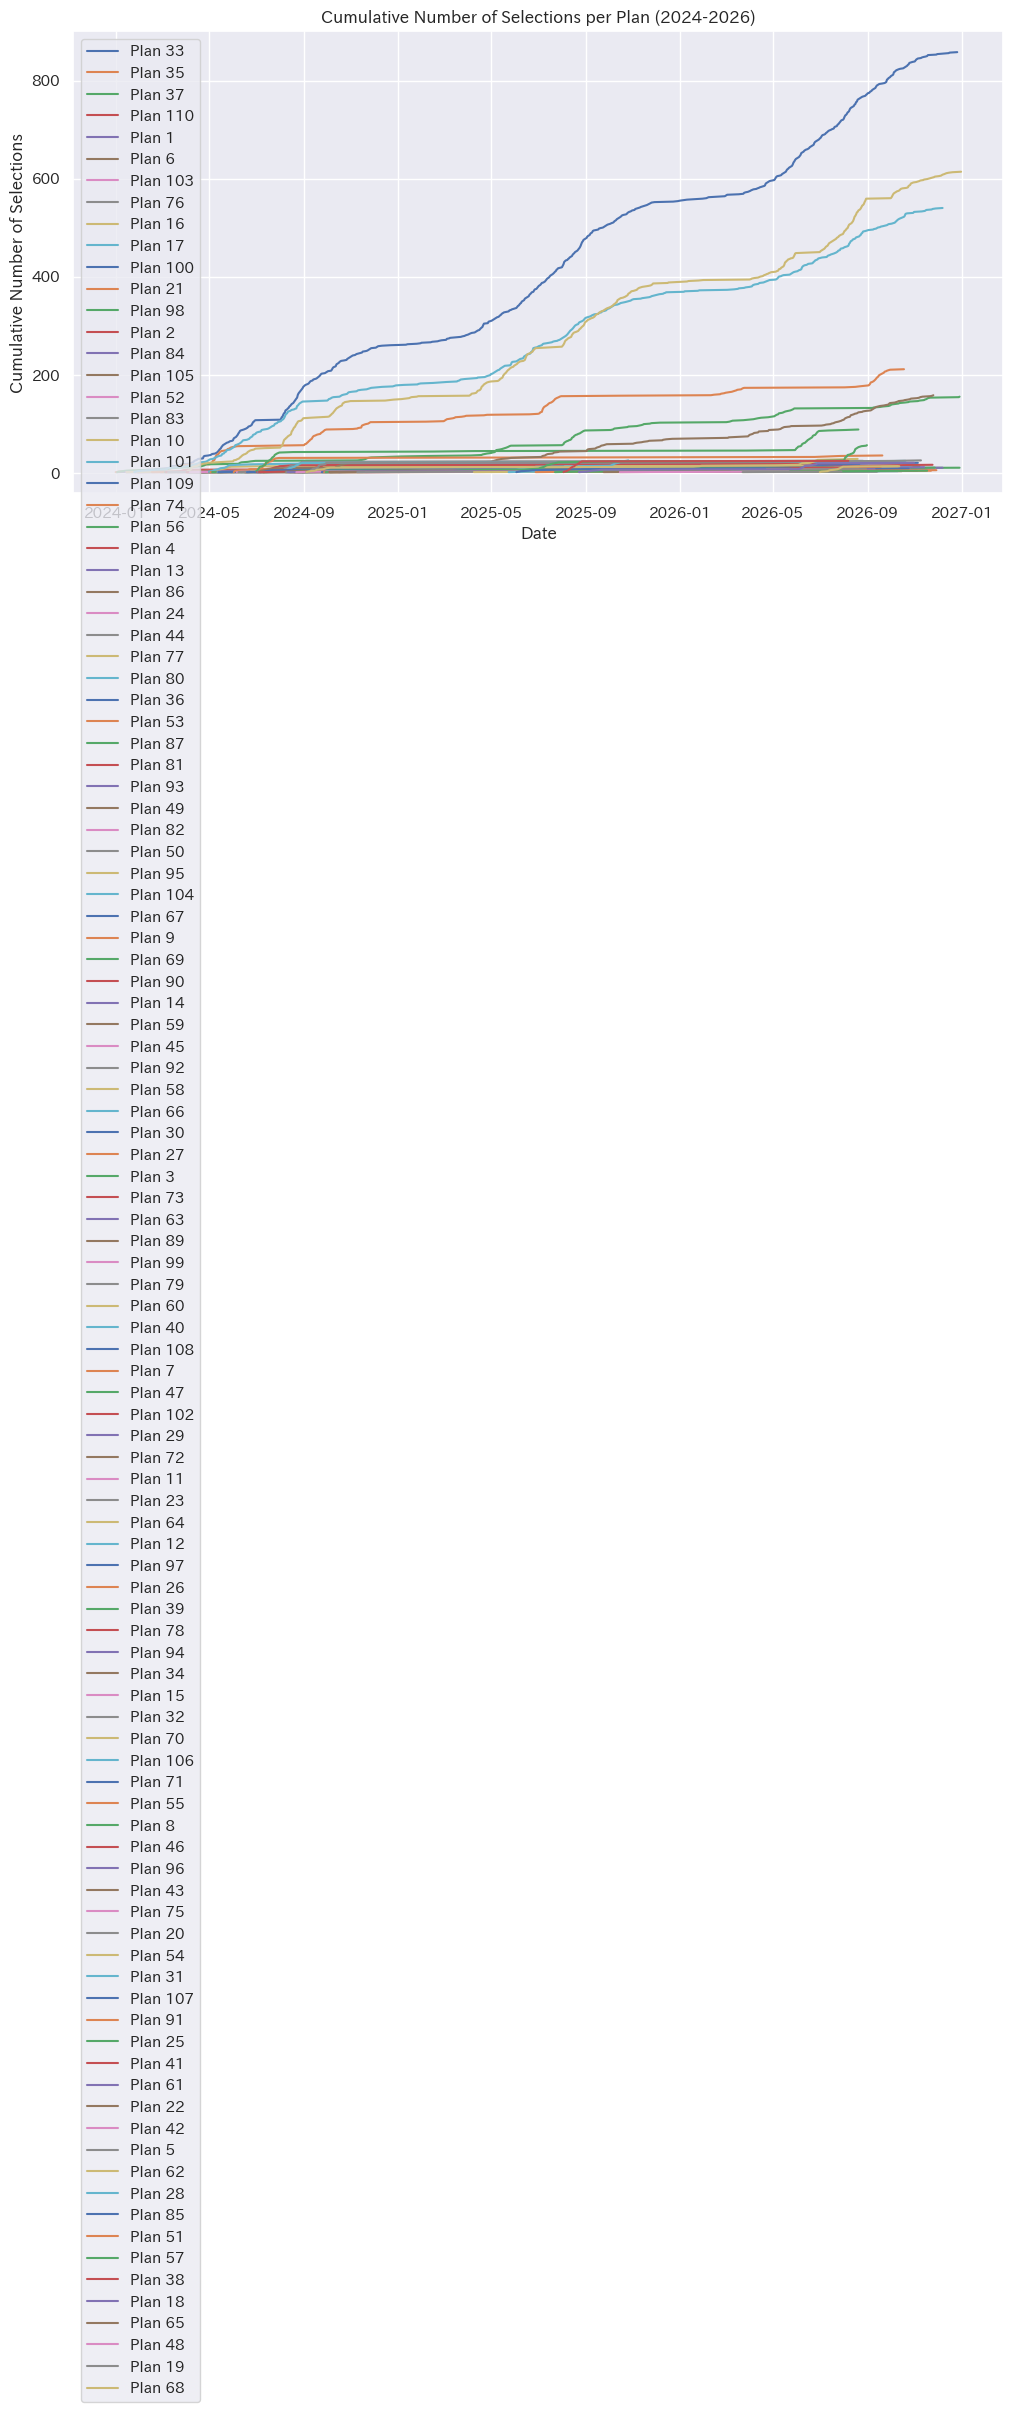

In [ ]:
# プランごとの日別選択人数を集計する関数
def plot_daily_plan_selections(analysis_results):
    plan_daily_counts = defaultdict(lambda: defaultdict(int))

    for year, yearly_data in analysis_results.items():
        for month, dataframe in yearly_data.items():
            for index, row in dataframe.iterrows():
                plan_id = row['select_plan']
                date = row['Initial_day']
                plan_daily_counts[plan_id][date] += 1

    # 日別データをデータフレームに変換
    plan_daily_counts_df = {plan_id: pd.Series(data).sort_index().cumsum()
                            for plan_id, data in plan_daily_counts.items()}

    # 折れ線グラフの描画
    plt.figure(figsize=(12, 6))
    for plan_id, counts in plan_daily_counts_df.items():
        plt.plot(counts.index, counts, label=f'Plan {plan_id}')

    plt.xlabel('Date')
    plt.ylabel('Cumulative Number of Selections')
    plt.title('Cumulative Number of Selections per Plan (2024-2026)')
    plt.legend()
    plt.show()

# 2024年から2026年までの結果に基づいてグラフを描画
plot_daily_plan_selections(analysis_results)


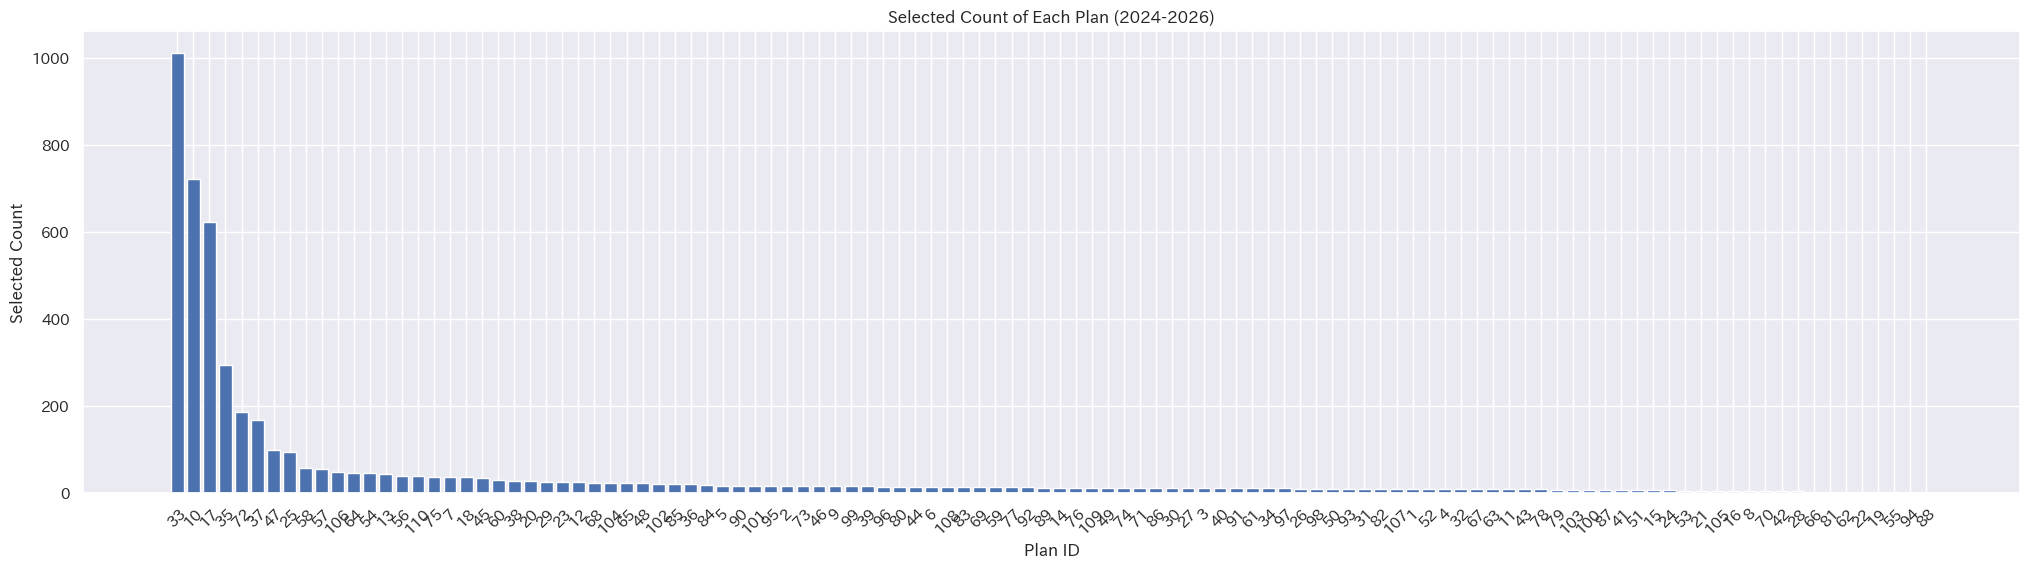

In [ ]:
# 2024年から2026年までの選択回数を更新してソートする関数
def update_and_sort_plans(all_simulation_results):
    selected_counts = defaultdict(int)
    for year, yearly_data in all_simulation_results.items():
        for month, dataframe in yearly_data.items():
            for index, row in dataframe.iterrows():
                plan_id = row['select_plan']
                selected_counts[plan_id] += 1

    # plansデータフレームを更新
    for plan_id, count in selected_counts.items():
        plans.loc[plans['ID'] == plan_id, 'Selected_count'] = count

    # ソートして返す
    return plans.sort_values('Selected_count', ascending=False)

# 選択回数のグラフを描画
sorted_plans = update_and_sort_plans(all_simulation_results)
plt.figure(figsize=(25, 6))
plt.bar(sorted_plans['ID'].astype(str), sorted_plans['Selected_count'])
plt.xlabel('Plan ID')
plt.ylabel('Selected Count')
plt.title('Selected Count of Each Plan (2024-2026)')
plt.xticks(rotation=45)
plt.show()

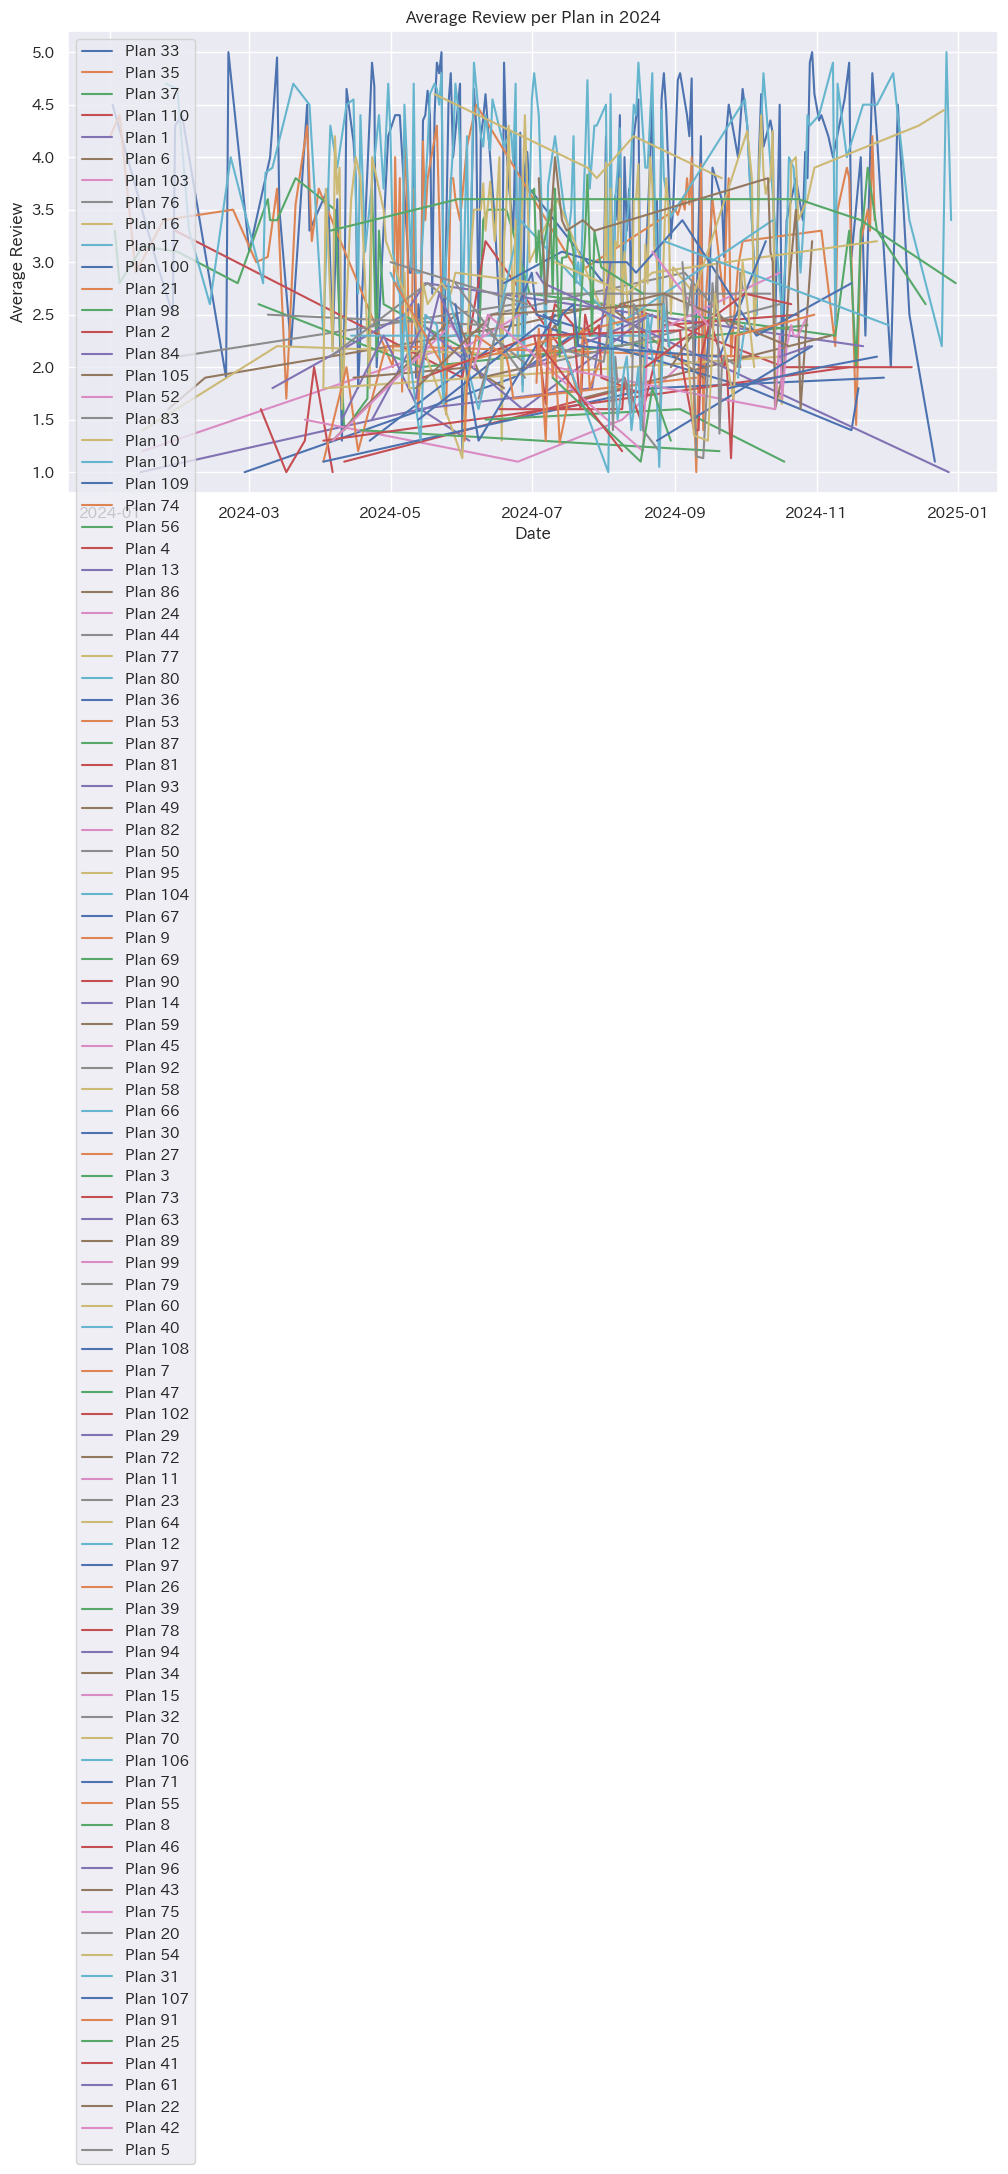

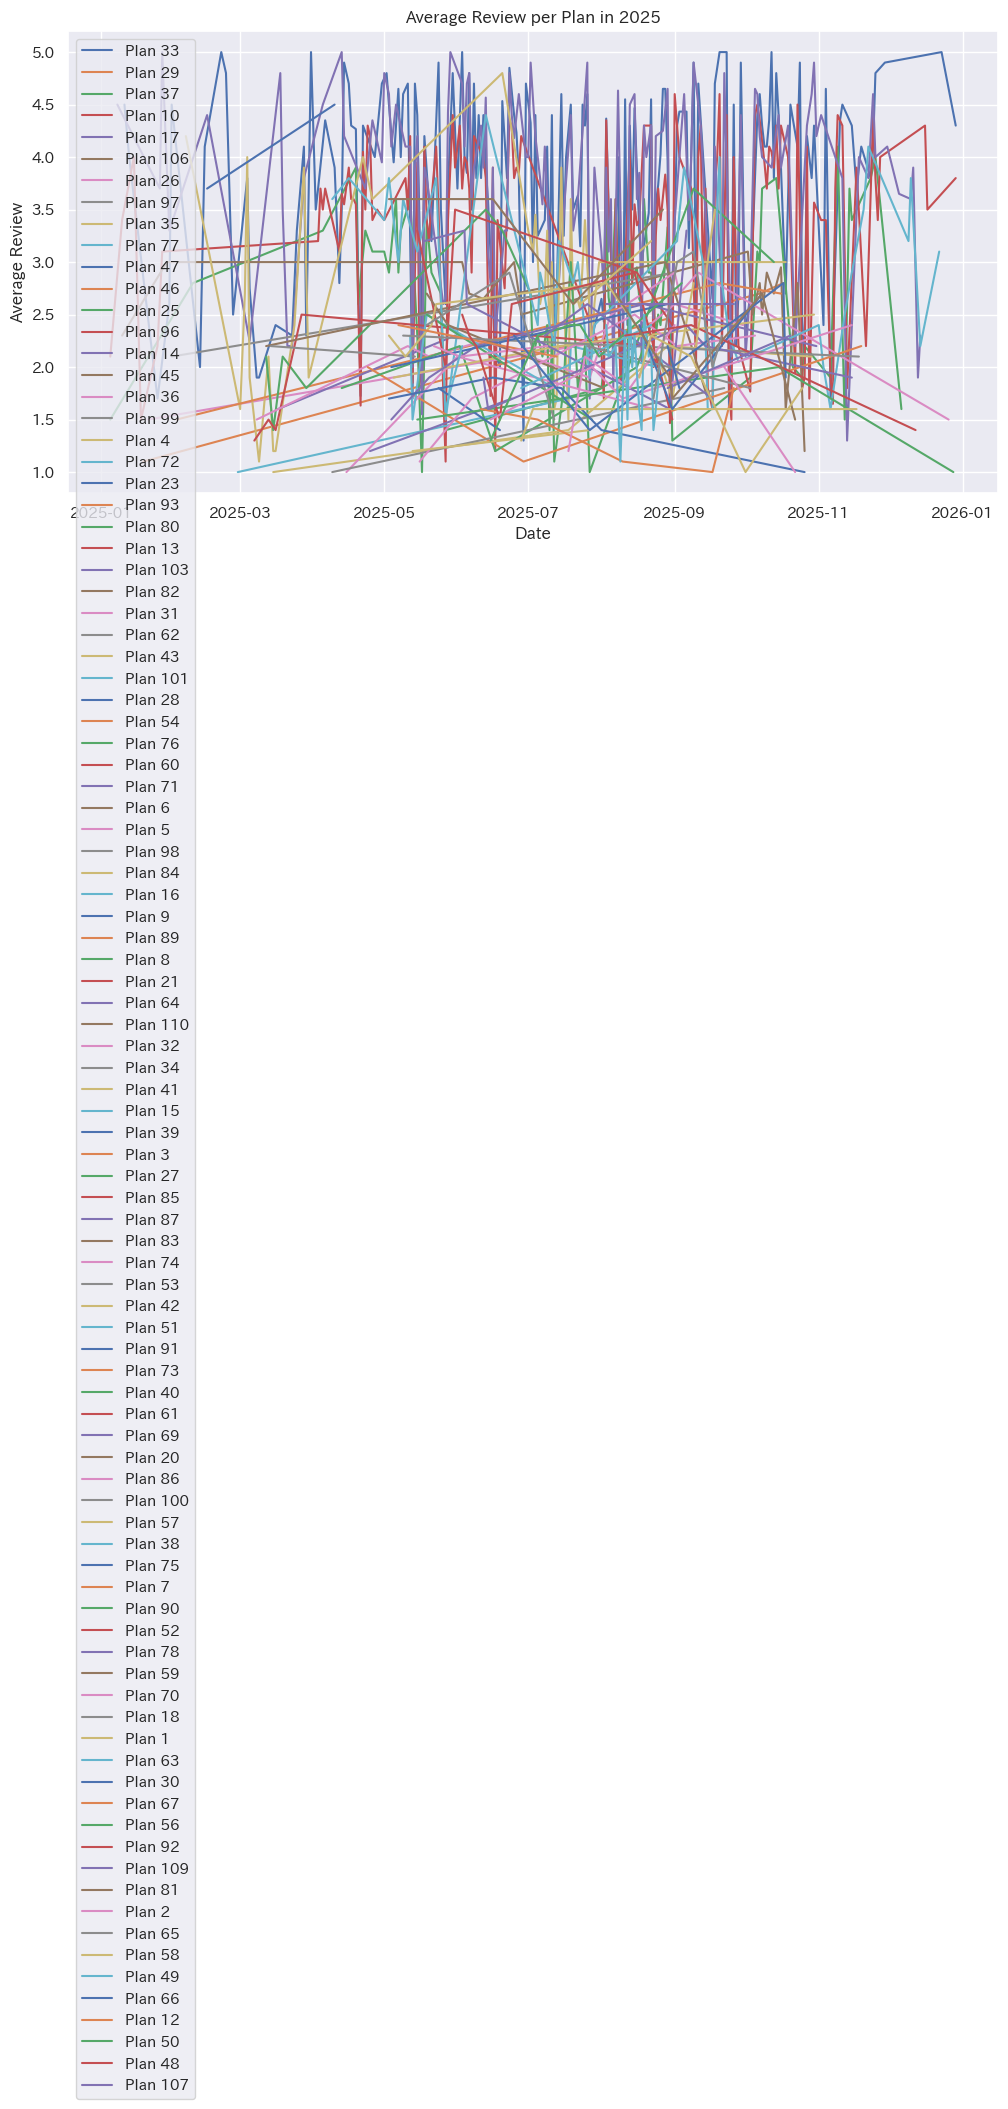

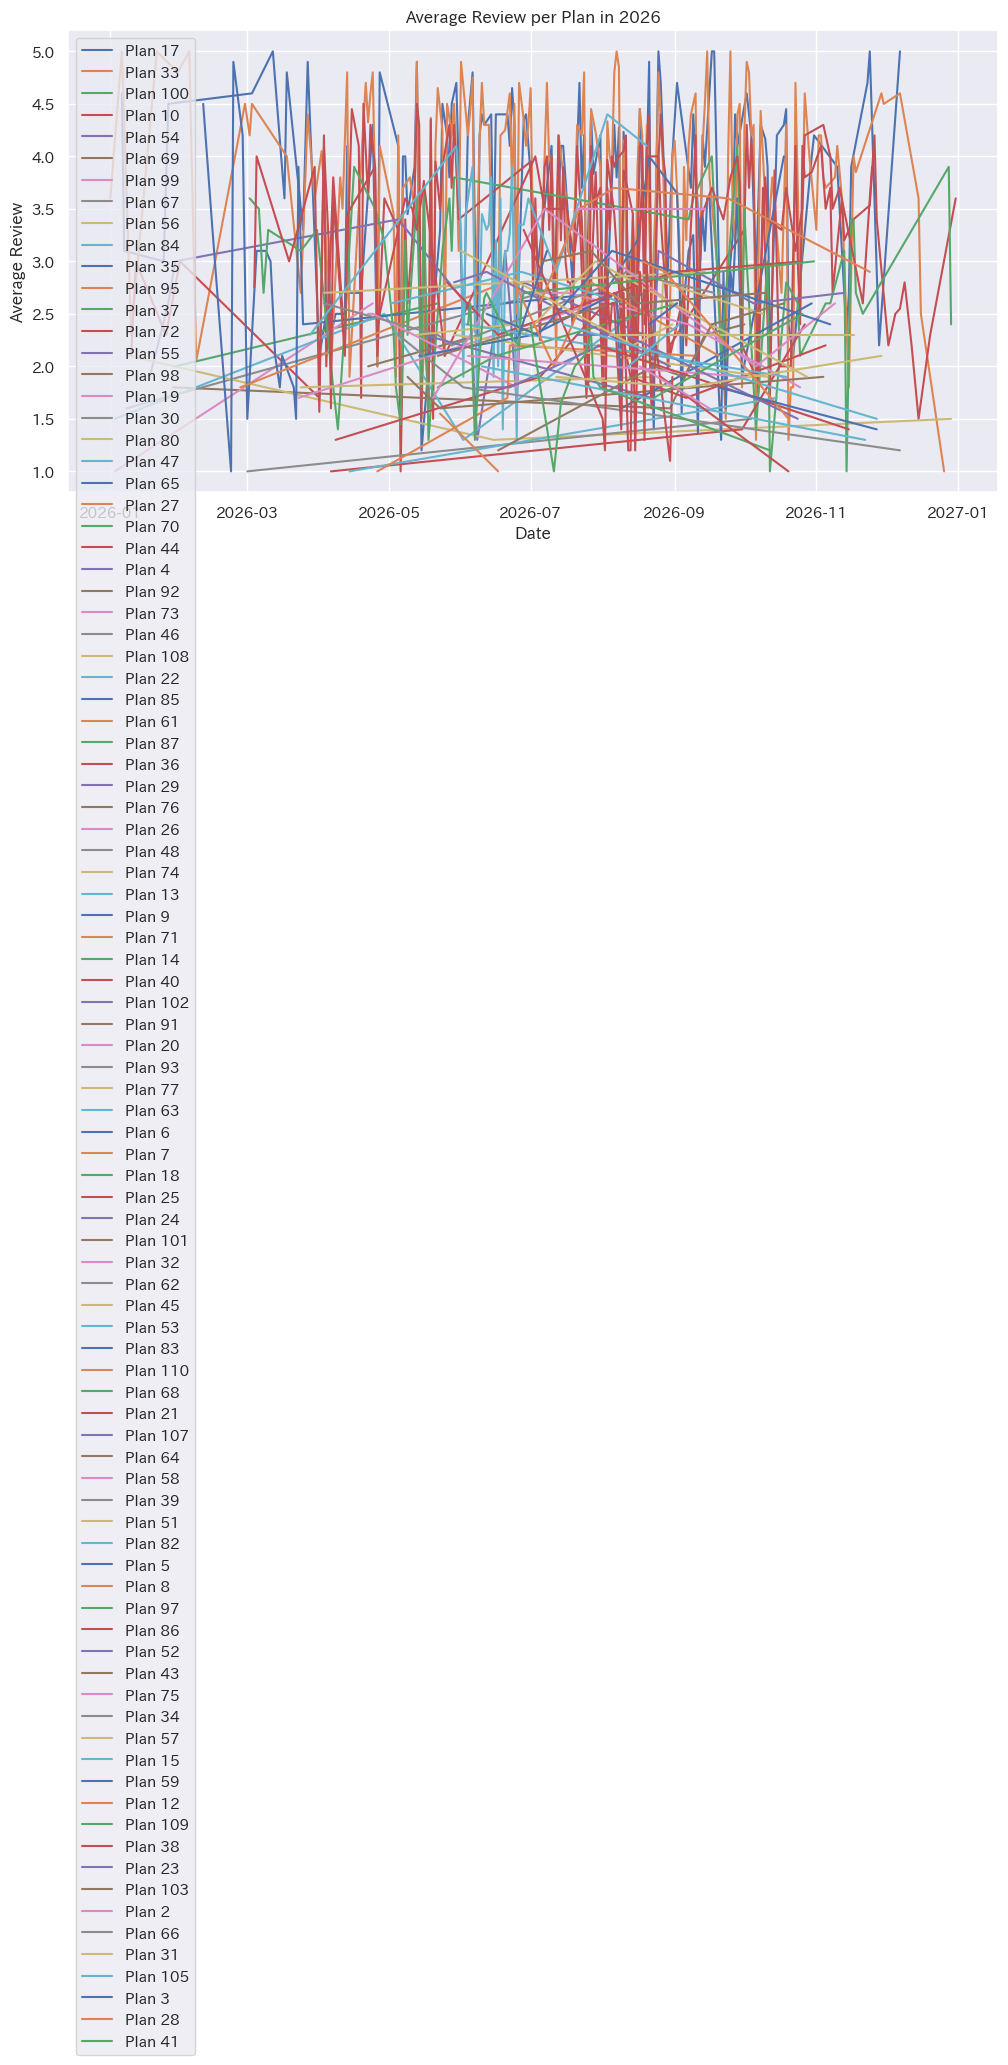

In [ ]:
# 年ごとのプランのレビュー平均を集計してグラフに表示する関数
def plot_yearly_plan_reviews(all_simulation_results):
    for year in range(2024, 2027):
        plan_daily_reviews = defaultdict(lambda: defaultdict(list))

        for month, dataframe in all_simulation_results[year].items():
            for index, row in dataframe.iterrows():
                plan_id = row['select_plan']
                date = row['Initial_day']
                review = row['Review']
                plan_daily_reviews[plan_id][date].append(review)

        # 日別データをデータフレームに変換し、日別平均を計算
        plan_daily_reviews_avg = {plan_id: pd.Series({date: sum(reviews) / len(reviews) for date, reviews in data.items()}).sort_index()
                                  for plan_id, data in plan_daily_reviews.items()}

        # 折れ線グラフの描画
        plt.figure(figsize=(12, 6))
        for plan_id, reviews in plan_daily_reviews_avg.items():
            plt.plot(reviews.index, reviews, label=f'Plan {plan_id}')

        plt.xlabel('Date')
        plt.ylabel('Average Review')
        plt.title(f'Average Review per Plan in {year}')
        plt.legend()
        plt.show()

plot_yearly_plan_reviews(all_simulation_results)

In [ ]:
import ast

In [ ]:
# Sightsカラムをリストに変換
plans['Sights'] = plans['Sights'].apply(lambda x: [facility.strip() for facility in x.split(',')])

# 変換後のSightsカラムの最初の数行を表示して確認
print(plans['Sights'].head())


0          [佐渡金山]
1    [佐渡金山, 尾畑酒造]
2     [佐渡金山, 妙宣寺]
3     [大佐渡スカイライン]
4           [白雲台]
Name: Sights, dtype: object


In [ ]:
# Sightsカラムの値が文字列の場合のみast.literal_evalを適用する関数
def safe_literal_eval(s):
    if isinstance(s, str):
        return ast.literal_eval(s)
    return s

# Sightsカラムをリストに変換
plans['Sights'] = plans['Sights'].apply(safe_literal_eval)

# その後の処理
# 施設ごとのプランIDを抽出
facility_plan_ids = {}
for index, row in plans.iterrows():
    for facility in row['Sights']:
        if facility not in facility_plan_ids:
            facility_plan_ids[facility] = []
        facility_plan_ids[facility].append(row['ID'])

# プランごとのレビューを集計
plan_reviews = {}
for (year, month), tourists in simulation_results.items():
    for index, row in tourists.iterrows():
        plan_id = row['select_plan']
        review = row['Review']
        if plan_id not in plan_reviews:
            plan_reviews[plan_id] = []
        plan_reviews[plan_id].append(review)

# 施設ごとの平均レビューを計算
facility_reviews = {}
for facility, plan_ids in facility_plan_ids.items():
    reviews = []
    for plan_id in plan_ids:
        reviews.extend(plan_reviews.get(plan_id, []))
    facility_reviews[facility] = sum(reviews) / len(reviews) if reviews else 0

# 施設ごとの平均レビューを表示
for facility, average_review in facility_reviews.items():
    print(f"{facility}: {average_review:.2f}")


佐渡金山: 2.01
尾畑酒造: 2.95
妙宣寺: 2.26
大佐渡スカイライン: 3.13
白雲台: 2.17
大野亀: 2.64
二ツ亀: 2.13
平根崎: 3.52
尖閣湾揚島遊園: 2.24
玉堂窯: 3.22
北沢浮遊選鉱場: 2.69
きらりうむ佐渡: 2.44
めおと岩観光: 2.05
根本寺: 2.35
トキの森公園: 3.55
佐渡博物館: 2.95
両津郷土博物館: 2.38
真野御陵: 2.55
長浜荘: 1.84
佐渡歴史伝説館: 2.58
佐渡西三川ゴールドパーク: 2.87
蓮華峰寺: 2.11
矢島・経島: 2.29
力屋観光汽船: 2.71
宿根木集落: 2.76
小木民俗博物館: 2.20
小木家（小木港）: 1.98
北雪酒造: 2.07


1. 佐渡金山が含まれるプランの広告力を調整する関数

In [ ]:
def adjust_sado_goldmine_ad_power(plans, ad_power_increase):
    adjusted_plans = plans.copy()
    for index, plan in adjusted_plans.iterrows():
        if "佐渡金山" in plan['Sights']:
            # 佐渡金山を含むプランの広告力を増加
            adjusted_plans.at[index, 'Ad_power'] += ad_power_increase
        else:
            # 佐渡金山を含まないプランの広告力を0.2に設定
            adjusted_plans.at[index, 'Ad_power'] = 0.2
    return adjusted_plans


2. 2024年から2026年までのシミュレーションを実行

In [ ]:
def run_simulation(yearly_counts_dict, plans, specified_year):
    simulation_results = {}

    predicted_counts_df = yearly_counts_dict[specified_year]
    crowd_df = generate_crowd(specified_year, 365)

    for month in range(1, 13):
        # 指定された年と月に基づいた予測観光客数を取得
        num_tourists = predicted_counts_df.loc[month, 'Predicted_Tourists']
        tourists = generate_tourists(num_tourists, 1, specified_year, month)

        selected_tourists = select_plans(tourists, plans)
        selected_tourists = calculate_expectation(selected_tourists, plans)

        # 混雑度を更新
        for plan_id in plans['ID']:
            selected_count = selected_tourists[selected_tourists['select_plan'] == plan_id].shape[0]
            congestion_value = min(selected_count / 10, 1)
            plans.loc[plans['ID'] == plan_id, 'Congestion'] = congestion_value

        selected_tourists = calculate_experience(selected_tourists, plans, crowd_df)

        # Satisfaction列の計算と追加
        for index, row in selected_tourists.iterrows():
            satisfaction = calculate_satisfaction(row, plans)
            selected_tourists.at[index, 'Satisfaction'] = satisfaction

        max_satisfaction = selected_tourists['Satisfaction'].max()
        min_satisfaction = selected_tourists['Satisfaction'].min()
        selected_tourists['Review'] = selected_tourists['Satisfaction'].apply(lambda s: scale_to_review(s, min_satisfaction, max_satisfaction))

        # プランのレビューと選択回数を更新
        plans = update_plan_ratings(selected_tourists, plans)

        simulation_results[(specified_year, month)] = selected_tourists

    return simulation_results, plans


In [ ]:
def adjust_sado_goldmine_ad_power(plans, ad_power_increase):
    adjusted_plans = plans.copy()
    for index, plan in adjusted_plans.iterrows():
        if "佐渡金山" in plan['Sights']:
            # 佐渡金山を含むプランの広告力を増加
            adjusted_plans.at[index, 'Ad_power'] += ad_power_increase
        else:
            # 佐渡金山を含まないプランの広告力を0.2に設定
            adjusted_plans.at[index, 'Ad_power'] = 0.2
    return adjusted_plans

# 佐渡金山が含まれるプランの広告力を高く設定
adjusted_plans = adjust_sado_goldmine_ad_power(plans, 0.5)

# 2024年から2026年までのシミュレーション結果を取得
sado_goldmine_simulation_results = {}
for year in range(2024, 2027):
    year_simulation_results = {}

    for month in range(1, 13):
        delta, lambda_value = (average_delta, average_lambda) if year > 2018 else calibrated_params[year]
        num_tourists = calculate_sado_tourists(year, month, delta, lambda_value, review_averages)
        crowd_df = generate_crowd(year, cal.monthrange(year, month)[1])

        tourists = generate_tourists(num_tourists, 1, year, month)
        selected_tourists = select_plans(tourists, adjusted_plans)
        selected_tourists = calculate_expectation(selected_tourists, adjusted_plans)
        selected_tourists = calculate_experience(selected_tourists, adjusted_plans, crowd_df)

        for index, row in selected_tourists.iterrows():
            satisfaction = calculate_satisfaction(row, adjusted_plans)
            selected_tourists.at[index, 'Satisfaction'] = satisfaction

        # 満足度の最大値と最小値を計算
        max_satisfaction = selected_tourists['Satisfaction'].max()
        min_satisfaction = selected_tourists['Satisfaction'].min()

        for index, row in selected_tourists.iterrows():
            review = scale_to_review(row['Satisfaction'], min_satisfaction, max_satisfaction)
            selected_tourists.at[index, 'Review'] = review

        adjusted_plans = update_plan_ratings(selected_tourists, adjusted_plans)
        year_simulation_results[month] = selected_tourists

    sado_goldmine_simulation_results[year] = year_simulation_results

# 世界遺産登録なしのシナリオのシミュレーション結果を格納
data1 = plot_cumulative_selections_for_sado_goldmine(all_simulation_results, sado_goldmine_plan_ids)

# 世界遺産登録ありのシナリオのシミュレーション結果を格納
data2 = plot_cumulative_selections_for_sado_goldmine(sado_goldmine_simulation_results, sado_goldmine_plan_ids)

NameError: name 'plot_cumulative_selections_for_sado_goldmine' is not defined

3. 比較分析を行う
a. 選択回数の差分を計算

In [ ]:
def select_plans(selected_tourists, plans):
    for index, tourist in selected_tourists.iterrows():
        # 観光客の選好ベクトルを作成
        pref_vec = np.array([tourist['Pref1'], tourist['Pref2'], tourist['Pref3'], tourist['Pref4']])

        # plansのAttrベクトルを作成し、観光客の選好ベクトルとのコサイン類似度を計算
        plans_vec = plans[['Attr1', 'Attr2', 'Attr3', 'Attr4']].values
        similarity = cosine_similarity(pref_vec.reshape(1, -1), plans_vec)

        # コサイン類似度が大きい順にplansを並べ替え
        plans['similarity'] = similarity.reshape(-1)
        sorted_plans = plans.sort_values(['similarity'], ascending=False)

        # 佐渡金山を含むプランの選択確率を高める
        if '佐渡金山' in sorted_plans['Sights'].iloc[0]:
            if np.random.rand() < 0.5:  # 50%の確率で佐渡金山を含むプランを選択
                selected_plan = sorted_plans.iloc[0]
            else:
                selected_plan = sorted_plans.iloc[1]  # それ以外の場合は次のプランを選択
        else:
            selected_plan = sorted_plans.iloc[0]  # 佐渡金山を含まない場合は最も好ましいプランを選択

        # 選択したプランを記録
        selected_tourists.at[index, 'select_plan'] = selected_plan['ID']

    return selected_tourists


In [ ]:
# 世界遺産登録ありのシナリオでのプランの広告力を調整
adjusted_plans = adjust_sado_goldmine_ad_power(plans, 0.5)

# 予測された観光客数のデータフレームを生成
yearly_predicted_counts = create_yearly_predicted_counts(range(2024, 2027), average_ratios, coefficients, review_averages, calibrated_params, average_delta, average_lambda)

# 世界遺産登録ありのシナリオのシミュレーションを実行
sado_goldmine_simulation_results = {}
for year in range(2024, 2027):
    simulation_results, updated_plans = run_simulation(yearly_predicted_counts, adjusted_plans, year)
    sado_goldmine_simulation_results[year] = simulation_results

In [ ]:
def plot_cumulative_selections_for_sado_goldmine(simulation_results, plan_ids):
    cumulative_counts = defaultdict(int)

    # 各年、各月のデータを反復処理
    for year, yearly_data in simulation_results.items():
        for month, dataframe in yearly_data.items():
            for date, rows in dataframe.groupby('Initial_day'):
                # 佐渡金山が含まれるプランの選択回数を日ごとに加算
                count = rows[rows['select_plan'].isin(plan_ids)].shape[0]
                cumulative_counts[date] += count

    # 日別データをデータフレームに変換し、累積値を計算
    cumulative_selections_df = pd.Series(cumulative_counts).sort_index().cumsum()

    # 折れ線グラフの描画
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_selections_df.index, cumulative_selections_df.values)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Selections')
    plt.title('Cumulative Selections for Plans Including Sado Goldmine')
    plt.show()

    return cumulative_selections_df


In [ ]:
# 佐渡金山を含むプランのIDを識別
sado_goldmine_plan_ids = [plan_id for plan_id, plan in plans.iterrows() if '佐渡金山' in plan['Sights']]

# 以降のコード
data1 = plot_cumulative_selections_for_sado_goldmine(all_simulation_results, sado_goldmine_plan_ids)
data2 = plot_cumulative_selections_for_sado_goldmine(sado_goldmine_simulation_results, sado_goldmine_plan_ids)


In [ ]:
# 世界遺産登録なしのシナリオのシミュレーション結果を格納
data1 = plot_cumulative_selections_for_sado_goldmine(all_simulation_results, sado_goldmine_plan_ids)

# 世界遺産登録ありのシナリオのシミュレーション結果を格納
data2 = plot_cumulative_selections_for_sado_goldmine(sado_goldmine_simulation_results, sado_goldmine_plan_ids)

In [ ]:
# 世界遺産登録なしのシナリオのシミュレーション結果を格納
data1 = plot_cumulative_selections_for_sado_goldmine(all_simulation_results, sado_goldmine_plan_ids)

# 世界遺産登録ありのシナリオのシミュレーション結果を格納
data2 = plot_cumulative_selections_for_sado_goldmine(sado_goldmine_simulation_results, sado_goldmine_plan_ids)

# 差分を計算
difference = data2 - data1

# 差分を数値で表示
print("差分（世界遺産登録あり - なし）:")
print(difference)

# 差分のグラフ表示
plt.figure(figsize=(12, 6))
plt.plot(difference.index, difference.values)
plt.xlabel('Date')
plt.ylabel('Difference in Cumulative Selections')
plt.title('Difference in Cumulative Selections for Plans Including Sado Goldmine (2024-2026)')
plt.show()


In [ ]:
def extract_reviews_for_sado_goldmine(simulation_results, plan_ids):
    reviews = defaultdict(list)

    # 各年、各月のデータを反復処理
    for year, yearly_data in simulation_results.items():
        for month, dataframe in yearly_data.items():
            for index, row in dataframe.iterrows():
                if row['select_plan'] in plan_ids:
                    reviews[row['Initial_day']].append(row['Review'])

    # 日別レビュースコアの平均を計算
    average_reviews = {date: np.mean(scores) if scores else None for date, scores in reviews.items()}
    return pd.Series(average_reviews).sort_index()


In [ ]:
# 佐渡金山が含まれるプランのIDを見つける
sado_goldmine_plan_ids = [plan_id for plan_id, plan in plans.iterrows() if '佐渡金山' in plan['Sights']]

# 世界遺産登録なしのシナリオのレビュースコアを抽出
reviews_no_registration = extract_reviews_for_sado_goldmine(all_simulation_results, sado_goldmine_plan_ids)

# 世界遺産登録ありのシナリオのレビュースコアを抽出
reviews_with_registration = extract_reviews_for_sado_goldmine(sado_goldmine_simulation_results, sado_goldmine_plan_ids)

# グラフ表示
plt.figure(figsize=(30, 6))
plt.plot(reviews_no_registration.index, reviews_no_registration.values, label='No World Heritage Registration')
plt.xlabel('Date')
plt.ylabel('Average Review Score')
plt.title('Average Review Scores for Plans Including Sado Goldmine (2024-2026)')
plt.legend()
plt.show()


In [ ]:
# 日付範囲を指定してデータをフィルタリング
start_date = '2024-01'
filtered_reviews_no_registration = reviews_no_registration[start_date:]
filtered_reviews_with_registration = reviews_with_registration[start_date:]

# グラフ表示
plt.figure(figsize=(30, 6))
plt.plot(filtered_reviews_no_registration.index, filtered_reviews_no_registration.values, label='No World Heritage Registration')
plt.plot(filtered_reviews_with_registration.index, filtered_reviews_with_registration.values, label='With World Heritage Registration')
plt.xlabel('Date')
plt.ylabel('Average Review Score')
plt.title('Average Review Scores for Plans Including Sado Goldmine (From 2024-01)')
plt.legend()
plt.show()


In [ ]:
def plot_cumulative_selections_for_sado_goldmine(simulation_results, plan_ids):
    cumulative_counts = defaultdict(int)

    # 各年、各月のデータを反復処理
    for year, yearly_data in simulation_results.items():
        for month, dataframe in yearly_data.items():
            for date, rows in dataframe.groupby('Initial_day'):
                # 佐渡金山が含まれるプランの選択回数を日ごとに加算
                count = rows[rows['select_plan'].isin(plan_ids)].shape[0]
                cumulative_counts[date] += count

    # 日別データをデータフレームに変換し、累積値を計算
    cumulative_selections_df = pd.Series(cumulative_counts).sort_index().cumsum()

    # 折れ線グラフの描画
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_selections_df.index, cumulative_selections_df.values)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Selections')
    plt.title('Cumulative Selections for Plans Including Sado Goldmine (2024-2026)')
    plt.show()

# 佐渡金山が含まれるプランの累積選択人数の推移を観察
plot_cumulative_selections_for_sado_goldmine(sado_goldmine_simulation_results, sado_goldmine_plan_ids)


In [ ]:
from collections import defaultdict
import pandas as pd

# 佐渡金山が含まれるプランの累積選択人数の推移を計算する関数
def calculate_cumulative_selections_for_sado_goldmine(simulation_results, plan_ids):
    cumulative_counts = defaultdict(int)

    # 各年、各月のデータを反復処理
    for year, yearly_data in simulation_results.items():
        for month, dataframe in yearly_data.items():
            for date, rows in dataframe.groupby('Initial_day'):
                # 佐渡金山が含まれるプランの選択回数を日ごとに加算
                count = rows[rows['select_plan'].isin(plan_ids)].shape[0]
                cumulative_counts[date] += count

    # 日別データをデータフレームに変換し、累積値を計算
    cumulative_selections_df = pd.Series(cumulative_counts).sort_index().cumsum()

    return cumulative_selections_df

# 佐渡金山が含まれるプランの累積選択人数のデータを計算
cumulative_selections_df = calculate_cumulative_selections_for_sado_goldmine(sado_goldmine_simulation_results, sado_goldmine_plan_ids)

# 結果を出力
print(cumulative_selections_df)


b. 時系列での選択人数の推移を観察

In [ ]:
def plot_facility_selections(simulation_results, plans):
    facility_daily_selections = defaultdict(lambda: defaultdict(int))

    for key, dataframe in simulation_results.items():
        for index, row in dataframe.iterrows():
            plan_id = row['select_plan']
            date = row['Initial_day']
            facilities_in_plan = plans.loc[plans['ID'] == plan_id, 'Sights'].iloc[0]
            for facility in facilities_in_plan:
                facility_daily_selections[facility][date] += 1

    facility_daily_selections_cumulative = {facility: pd.Series(data).sort_index().cumsum()
                                            for facility, data in facility_daily_selections.items()}

    for facility, selections in facility_daily_selections_cumulative.items():
        plt.figure(figsize=(20, 6))  # グラフのサイズを横長に設定
        plt.plot(selections.index, selections, label=f'{facility}')
        plt.xlabel('日付')
        plt.ylabel('累積選択回数')
        plt.title(f'{facility} の累積選択回数')
        plt.legend()
        plt.show()

# グラフを出力
plot_facility_selections(simulation_results, plans)


In [ ]:
def run_simulation(predicted_counts_df, facilities, plans, specified_year=None):
    simulation_results = {}

    # predicted_counts_dfの各行をイテレートする
    for index, row in predicted_counts_df.iterrows():
        year, month = index  # indexからyearとmonthを取得
        num_tourists = row['Predicted_Tourists']

        # 指定された年のデータのみを使用する場合、他の年のデータは無視
        if specified_year is not None and year != specified_year:
            continue

        crowd_df = generate_crowd(year, 365)

        tourists = generate_tourists(num_tourists, 1, year, month)

        selected_tourists = select_plans(tourists, plans)
        selected_tourists = calculate_expectation(selected_tourists, plans)

        # 混雑度を更新
        for plan_id in plans['ID']:
            selected_count = selected_tourists[selected_tourists['select_plan'] == plan_id].shape[0]
            congestion_value = min(selected_count / 10, 1)
            plans.loc[plans['ID'] == plan_id, 'Congestion'] = congestion_value

        selected_tourists = calculate_experience(selected_tourists, plans, crowd_df)

        # Satisfaction列の計算と追加
        for index, row in selected_tourists.iterrows():
            satisfaction = calculate_satisfaction(row, plans)
            selected_tourists.at[index, 'Satisfaction'] = satisfaction

        max_satisfaction = selected_tourists['Satisfaction'].max()
        min_satisfaction = selected_tourists['Satisfaction'].min()
        selected_tourists['Review'] = selected_tourists['Satisfaction'].apply(lambda s: scale_to_review(s, min_satisfaction, max_satisfaction))

        plans = update_plan_ratings(selected_tourists, plans)

        simulation_results[(year, month)] = selected_tourists

    return simulation_results, plans



##シナリオテスト

世界遺産登録なし


In [ ]:
def create_yearly_predicted_counts(years, average_ratios, coefficients, review_averages, calibrated_params, average_delta, average_lambda):
    predicted_counts = {}
    for year in years:
        predicted_counts[year] = pd.DataFrame(columns=['Predicted_Tourists'])

        for month in range(1, 13):
            if year <= 2018:
                delta, lambda_value = calibrated_params[year]
            else:
                delta, lambda_value = average_delta, average_lambda

            predicted_tourists = calculate_sado_tourists(year, month, delta, lambda_value, review_averages)
            predicted_counts[year].loc[month] = predicted_tourists

    return predicted_counts

# 予測された観光客数のデータフレームを生成
predicted_counts_df_2024 = create_yearly_predicted_counts(range(2024, 2027), average_ratios, coefficients, review_averages, calibrated_params, average_delta, average_lambda)


In [ ]:
def run_simulation(yearly_counts_dict, facilities, plans, specified_year):
    simulation_results = {}

    predicted_counts_df = yearly_counts_dict[specified_year]
    crowd_df = generate_crowd(specified_year, 365)

    for month in range(1, 13):
        num_tourists = predicted_counts_df.loc[month, 'Predicted_Tourists']
        tourists = generate_tourists(num_tourists, 1, specified_year, month)

        selected_tourists = select_plans(tourists, plans)
        selected_tourists = calculate_expectation(selected_tourists, plans)
        selected_tourists = calculate_experience(selected_tourists, plans, crowd_df)

        for index, row in selected_tourists.iterrows():
            satisfaction = calculate_satisfaction(row, plans)
            selected_tourists.at[index, 'Satisfaction'] = satisfaction

        max_satisfaction = selected_tourists['Satisfaction'].max()
        min_satisfaction = selected_tourists['Satisfaction'].min()
        selected_tourists['Review'] = selected_tourists['Satisfaction'].apply(lambda s: scale_to_review(s, min_satisfaction, max_satisfaction))

        plans = update_plan_ratings(selected_tourists, plans)

        simulation_results[(specified_year, month)] = selected_tourists

    return simulation_results, plans

def plot_cumulative_selections_for_sado_goldmine(simulation_results, plan_ids):
    cumulative_counts = defaultdict(int)

    # 各年、各月のデータを反復処理
    for year, yearly_data in simulation_results.items():
        for month, dataframe in yearly_data.items():
            for date, rows in dataframe.groupby('Initial_day'):
                # 佐渡金山が含まれるプランの選択回数を日ごとに加算
                count = rows[rows['select_plan'].isin(plan_ids)].shape[0]
                cumulative_counts[date] += count

    # 日別データをデータフレームに変換し、累積値を計算
    cumulative_selections_df = pd.Series(cumulative_counts).sort_index().cumsum()

    # 折れ線グラフの描画
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_selections_df.index, cumulative_selections_df.values)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Selections')
    plt.title('Cumulative Selections for Plans Including Sado Goldmine (2024-2026, No World Heritage Registration)')
    plt.show()

# 佐渡金山が含まれるプランの累積選択人数の推移を観察
plot_cumulative_selections_for_sado_goldmine(sado_goldmine_simulation_results, sado_goldmine_plan_ids)


In [ ]:
from collections import defaultdict

def extract_cumulative_selections_data(simulation_results, plan_ids):
    cumulative_counts = defaultdict(int)

    # 各年、各月のデータを反復処理
    for year, yearly_data in simulation_results.items():
        for month, dataframe in yearly_data.items():
            for date, rows in dataframe.groupby('Initial_day'):
                # 佐渡金山が含まれるプランの選択回数を日ごとに加算
                count = rows[rows['select_plan'].isin(plan_ids)].shape[0]
                cumulative_counts[date] += count

    # 日別データをデータフレームに変換し、累積値を計算
    cumulative_selections_df = pd.Series(cumulative_counts).sort_index().cumsum()

    return cumulative_selections_df

# 佐渡金山が含まれるプランの累積選択人数のデータを取得
cumulative_selections_data = extract_cumulative_selections_data(sado_goldmine_simulation_results, sado_goldmine_plan_ids)

# 結果を出力
print(cumulative_selections_data)


In [ ]:
def calculate_cumulative_counts(simulation_results, plan_ids):
    cumulative_counts = defaultdict(int)

    for year, yearly_data in simulation_results.items():
        for month, dataframe in yearly_data.items():
            for date, rows in dataframe.groupby('Initial_day'):
                count = rows[rows['select_plan'].isin(plan_ids)].shape[0]
                cumulative_counts[date] += count

    return pd.Series(cumulative_counts).sort_index().cumsum()

# 世界遺産ありの累積選択人数を計算
cumulative_counts_with_registration = calculate_cumulative_counts(sado_goldmine_simulation_results_with_registration, sado_goldmine_plan_ids)

# 世界遺産なしの累積選択人数を計算
cumulative_counts_without_registration = calculate_cumulative_counts(sado_goldmine_simulation_results, sado_goldmine_plan_ids)

# 差分を計算
difference = cumulative_counts_with_registration - cumulative_counts_without_registration

# 差分を表示
print(difference)
